In [1]:
# How do Classical feedforward neural networks perform when making predictions over random noise?
# looking at nets from 
# saved_models/Converted_MNIST_Nets/

In [2]:
from __future__ import print_function

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import scipy as sp
from scipy import stats
from sklearn.utils import shuffle as shuffle_in_unison


import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [4]:
# # random seeds
# torch.manual_seed(1665)
# np.random.seed(3266)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [5]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)

# manualy set cuda device
torch.cuda.set_device(1)

CUDA Available:  True
Using device: cuda


In [6]:
# create random 28*28 images

# Random images dataset
x_rand = np.random.randint(low=0, high=255, size=(10000,28,28) )
#apply same transforms as for MNIST training
x_rand = x_rand/255.0
x_rand = (x_rand-0.1307)/0.3081

# print(np.mean(x_rand))
# print(np.std(x_rand))

x_rand = torch.Tensor(x_rand)


rand_dataset = torch.utils.data.TensorDataset(x_rand)# create your dataset
rand_dataloader = torch.utils.data.DataLoader(rand_dataset, 
                                              batch_size=32, 
                                              ) # create your dataloader

Shape: torch.Size([10000, 28, 28])
torch.Size([28, 28])


<IPython.core.display.Javascript object>


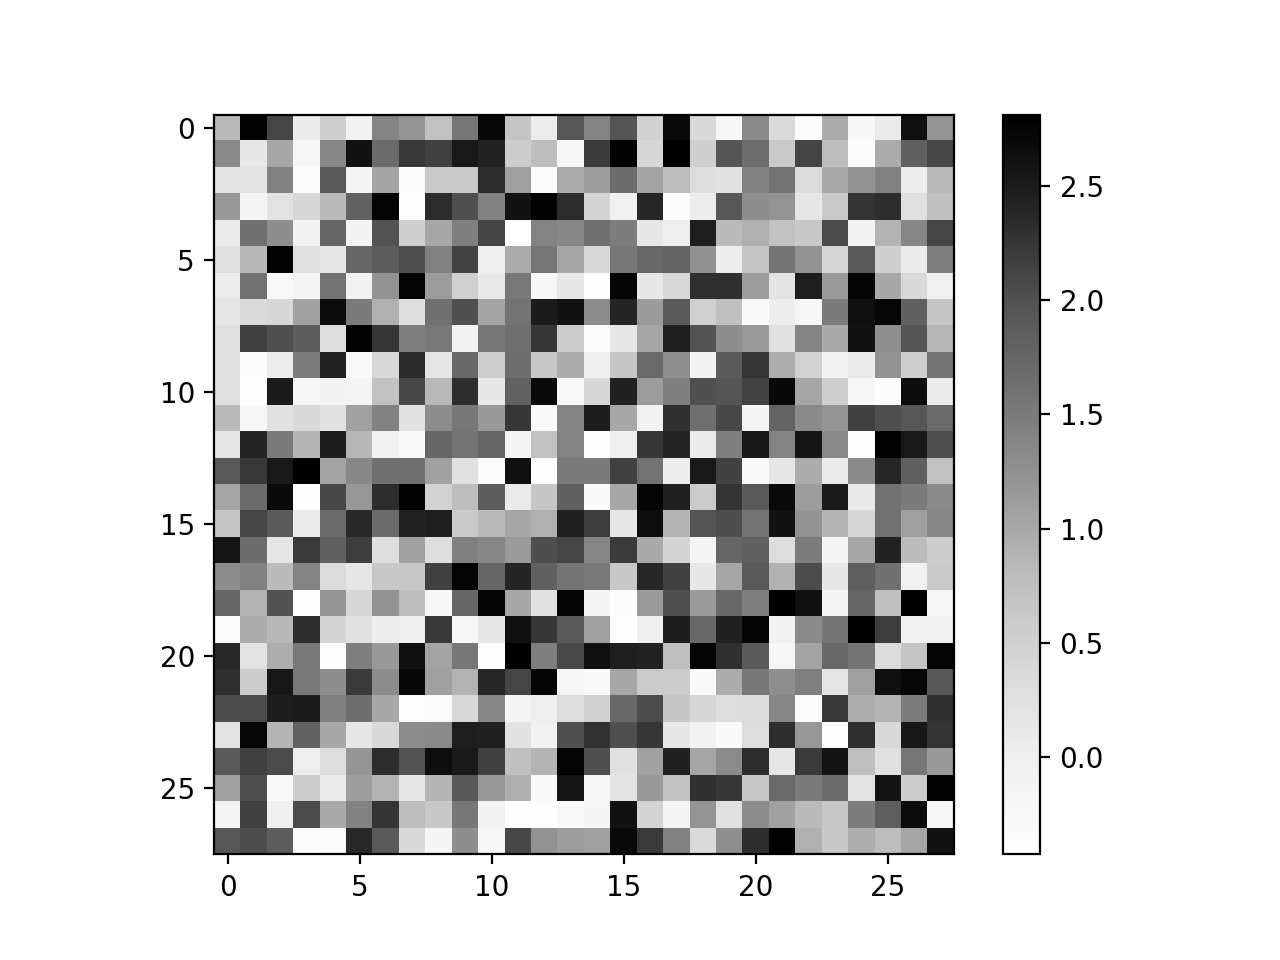

In [7]:
# show an example
print("Shape:", rand_dataloader.dataset.tensors[0].shape)
x = rand_dataloader.dataset.tensors[0][0]
print(x.shape)
# print("sample:", x)

plt.imshow(x, cmap=plt.cm.get_cmap('Greys'))
plt.colorbar()
plt.show()

In [9]:
# MNIST dataset and dataloader declaration
# transforms does both the conversion from 0-255 to 0-1
# and normalizes by the precomputed mean and std

batch_size = 192

mnist_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../../MNIST-dataset', train=True, download=False, 
                   transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
            ])), 
        batch_size=batch_size, shuffle=True)

mnist_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../../MNIST-dataset', train=False, download=False, 
                   transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
            ])), 
        batch_size=batch_size, shuffle=True)

In [10]:
# functions for test
# nll loss function
def classic_nll_loss_func(model, output, target):
    return F.nll_loss(output, target)
# number of correct pred function for classic net
def classic_pred_func(output, target):
    output = output
    pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    correct = pred.eq(target.long().view_as(pred)).sum().item()
    return correct

# nll loss function
def fgn_nll_loss_func(model, output, target):
#     # split output into pred and likelihoods
#     output, likelihood = output
    return F.nll_loss(output, target)    
# number of correct pred function for fgnet
def fgn_pred_func(output, target):
#     # split output into pred and likelihoods
#     output,_ = output
    pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    correct = pred.eq(target.long().view_as(pred)).sum().item()
    return correct

In [10]:
classic_model_dir = "./saved_models/Classic_MNIST_Nets/"
# pre-trained converted (not retrained) model 
converted_model_dir = "./saved_models/Converted_MNIST_Nets/"
# list of sizes
network_sizes = [[], [8], [128], [1024], [8,8], [128,128], [1024,1024], [8,8,8], [128,128,128], [1024,1024,1024]]

../Experiments/sample_models/sample_fgn_model_long_full.pth


In [30]:
# create classic model
classic_model = th.Classic_MNIST_Net(hidden_l_nums=s)
#state dict
# dict load
classic_model_path = classic_model_dir+'/model_'+str(s)+'_exp_'+str(exp_num)+'_state_dict.pth'
print(classic_model_path)
classic_model.to(device)
classic_model.load_state_dict(torch.load(classic_model_path))
print("Classic Model loaded")

./saved_models/Classic_MNIST_Nets//model_[128, 128]_exp_0_state_dict.pth
Classic Model loaded


In [31]:
# create fgn model
converted_fgn_model = th.Feedforward_FGN_net(28*28,10,s).to(device)
#state dict
# dict load
converted_fgn_model_path = converted_model_dir+'/fgn_model_'+str(s)+'_exp_'+str(exp_num)+'_state_dict.pth'
print(converted_fgn_model_path)
converted_fgn_model.to(device)
converted_fgn_model.load_state_dict(torch.load(converted_fgn_model_path))
# if the above model is old (with PIs, likelihood computation, convert)

print("converted FGN Model loaded")

./saved_models/Converted_MNIST_Nets//fgn_model_[128, 128]_exp_0_state_dict.pth
converted FGN Model loaded


In [32]:
# Check that accuracy is close
# classic model perf
classic_test_res = th.test(classic_model, device, mnist_test_loader, loss_func=classic_nll_loss_func, verbose=True, pred_func=classic_pred_func)
# perf (check that same or close to above)
fgn_test_res = th.test(converted_fgn_model, device, mnist_test_loader, loss_func=fgn_nll_loss_func, verbose=True, pred_func=fgn_pred_func)
if fgn_test_res['test_accuracy'] < 0.95*classic_test_res['test_accuracy']:
    print("Error during conversion")
else:
    print("Conversion successful")

Test set - Average loss: 0.1019, Accuracy: 9681/10000 (97%)
Test set - Average loss: 0.8806, Accuracy: 9654/10000 (97%)
Conversion successful


In [33]:
# apply models to random data
# get classic predictions 
classic_predictions = np.array([])
for data in rand_dataloader:
    data = data[0].to(device)
    pred = classic_model(data)
    pred = pred.cpu().detach().numpy()
    try:
        classic_predictions = np.concatenate((classic_predictions,pred))
    except:
        classic_predictions=pred
        
# for some reason the networks make log_softmax predictions
classic_predictions = np.exp(classic_predictions)

In [34]:
# print first 5 pred
print(np.round(classic_predictions[:5],decimals=2))
print("shape:", classic_predictions.shape)

[[0.01 0.   0.   0.   0.03 0.   0.01 0.   0.86 0.1 ]
 [0.01 0.   0.   0.06 0.   0.   0.   0.   0.86 0.07]
 [0.1  0.   0.01 0.04 0.04 0.   0.04 0.   0.74 0.04]
 [0.04 0.01 0.01 0.06 0.01 0.   0.02 0.   0.81 0.05]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.83 0.15]]
shape: (10000, 10)


In [35]:
# get fgn predictions 
fgn_predictions = np.array([])
for data in rand_dataloader:
    data = data[0].to(device)
#     # (old) split output into pred and negative likelihood
#     pred,_ = converted_fgn_model(data)
    pred = converted_fgn_model(data)
    pred = pred.cpu().detach().numpy()
    try:
        fgn_predictions = np.concatenate((fgn_predictions,pred))
    except:
        fgn_predictions=pred
        
# for some reason the networks make log_softmax predictions
fgn_predictions = np.exp(fgn_predictions)

In [36]:
# print first 5 pred
print(np.round(fgn_predictions[:5],decimals=2))
print("shape:", fgn_predictions.shape)

[[0.09 0.04 0.04 0.05 0.13 0.02 0.09 0.03 0.35 0.16]
 [0.12 0.04 0.09 0.16 0.04 0.02 0.03 0.04 0.32 0.16]
 [0.14 0.05 0.07 0.11 0.1  0.02 0.09 0.03 0.26 0.12]
 [0.12 0.07 0.08 0.12 0.08 0.02 0.09 0.04 0.27 0.11]
 [0.08 0.05 0.05 0.08 0.08 0.02 0.07 0.03 0.35 0.21]]
shape: (10000, 10)


<IPython.core.display.Javascript object>


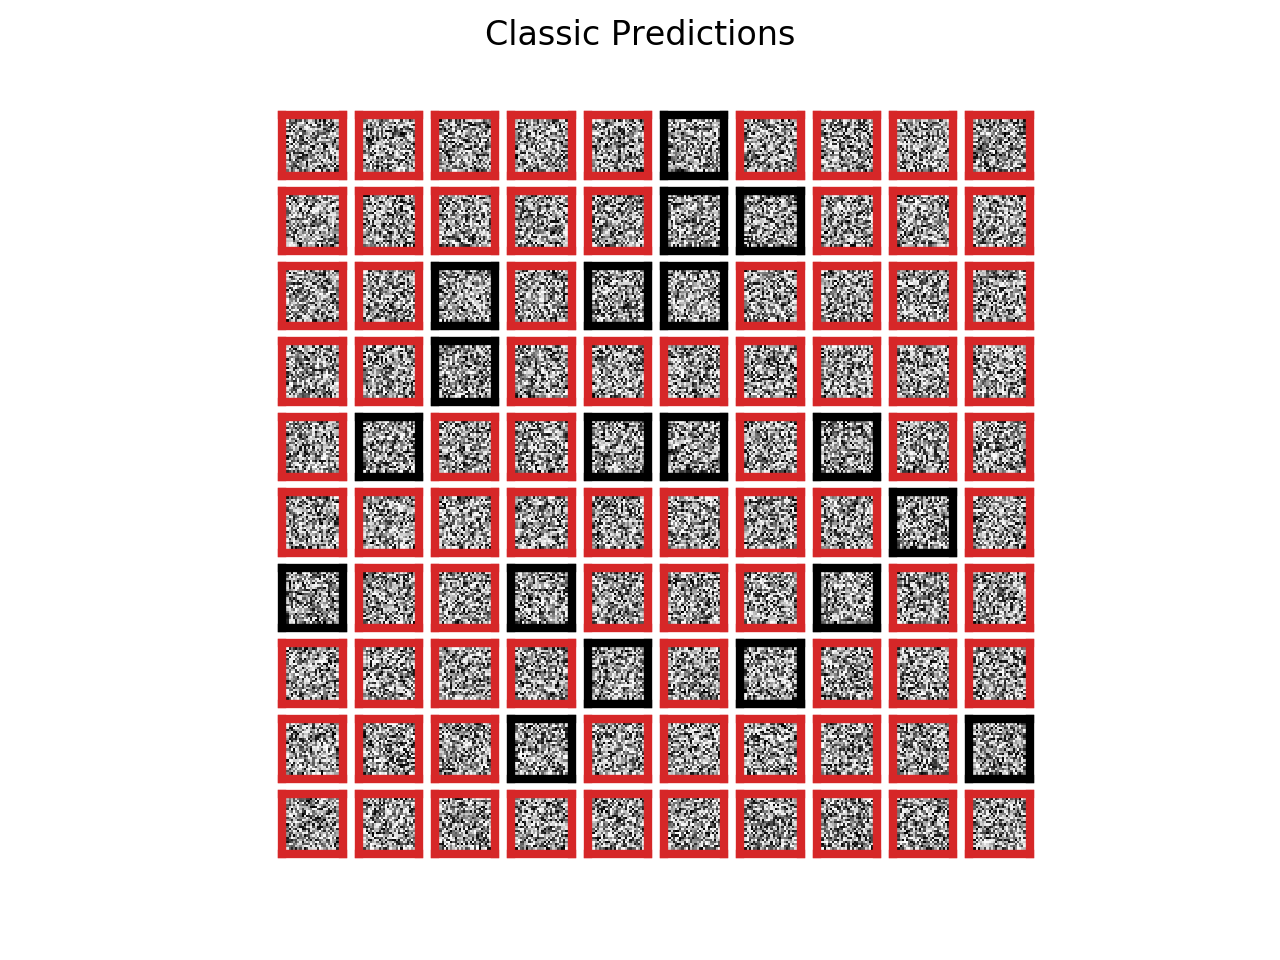

In [37]:
# plot and compare
# plot first 100 classic pred
fig, axes = plt.subplots(nrows=10, ncols=10)
for r in range(10):
    for c in range(10):
        
        x = rand_dataloader.dataset[10*r+c][0].numpy().reshape((28,28))
        
        # is the max bigger than rest combined?
        if np.max(classic_predictions[10*r+c])>=0.5:
            axes[r,c].spines['bottom'].set_color('tab:red')
            axes[r,c].spines['top'].set_color('tab:red')
            axes[r,c].spines['left'].set_color('tab:red')
            axes[r,c].spines['right'].set_color('tab:red')
        
        # is the max close to the min?
        if np.max(classic_predictions[10*r+c])<=0.2:            
            axes[r,c].spines['bottom'].set_color('tab:blue')
            axes[r,c].spines['top'].set_color('tab:blue')
            axes[r,c].spines['left'].set_color('tab:blue')
            axes[r,c].spines['right'].set_color('tab:blue')
            
        axes[r,c].spines['bottom'].set_linewidth(3)
        axes[r,c].spines['top'].set_linewidth(3)
        axes[r,c].spines['left'].set_linewidth(3)
        axes[r,c].spines['right'].set_linewidth(3)
        axes[r,c].tick_params(axis='both', labelbottom='off', labelleft='off', bottom='off', left='off')

        axes[r,c].imshow(x, cmap=plt.cm.get_cmap('Greys'))
#         axes[r,c].axis('off')
plt.subplots_adjust(wspace=-0.75, hspace=0.25)
fig.suptitle('Classic Predictions')
plt.show()

<IPython.core.display.Javascript object>


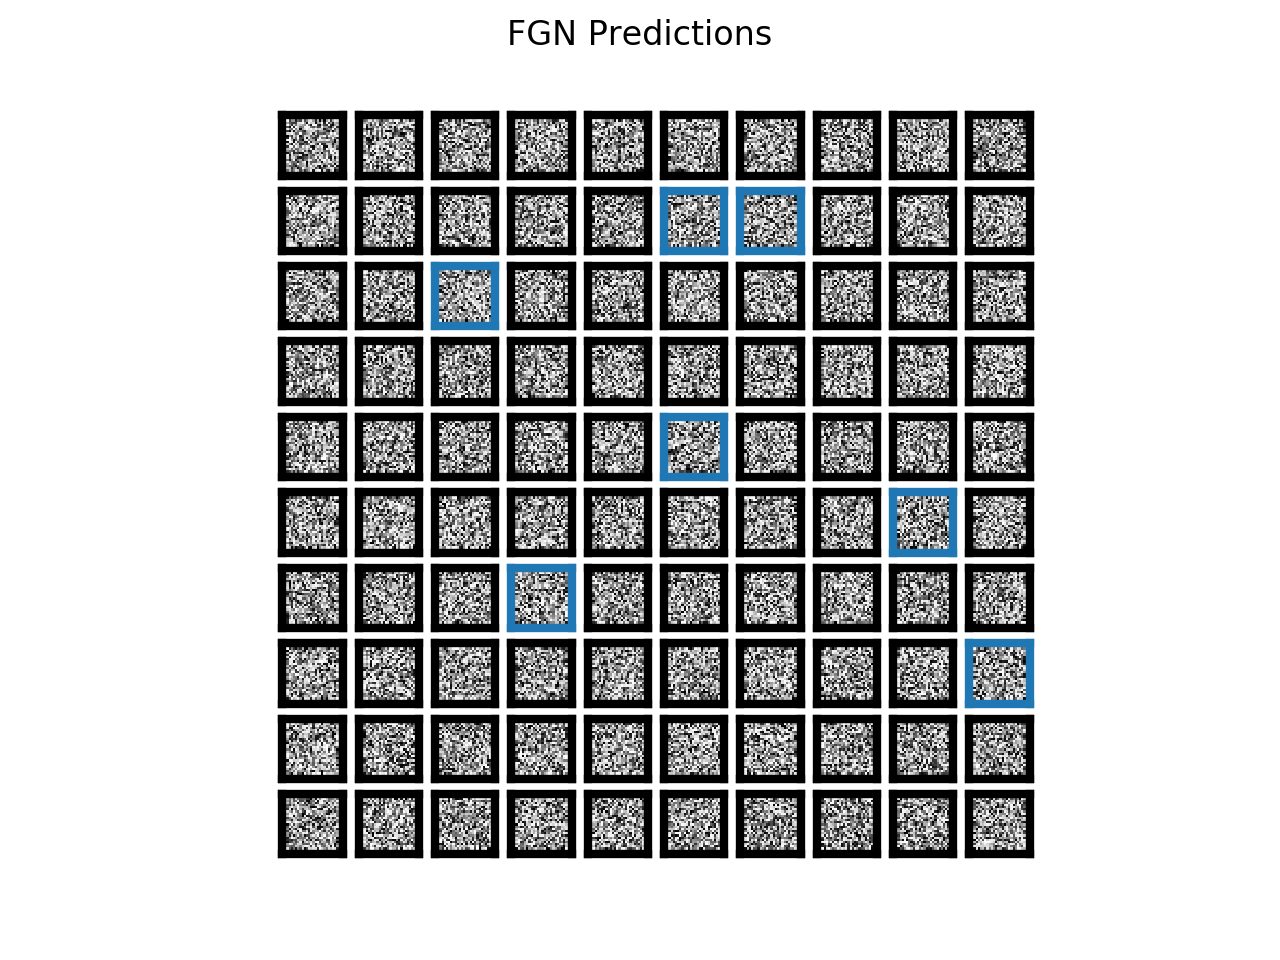

In [38]:
# plot and compare
# plot first 100 fgn preds
fig, axes = plt.subplots(nrows=10, ncols=10)
for r in range(10):
    for c in range(10):
        
        x = rand_dataloader.dataset[10*r+c][0].numpy().reshape((28,28))
        
        # is the max bigger than rest combined?
        if np.max(fgn_predictions[10*r+c])>=0.5:
            axes[r,c].spines['bottom'].set_color('tab:red')
            axes[r,c].spines['top'].set_color('tab:red')
            axes[r,c].spines['left'].set_color('tab:red')
            axes[r,c].spines['right'].set_color('tab:red')
        
        # is the max close to the min?
        if np.max(fgn_predictions[10*r+c])<=0.2:            
            axes[r,c].spines['bottom'].set_color('tab:blue')
            axes[r,c].spines['top'].set_color('tab:blue')
            axes[r,c].spines['left'].set_color('tab:blue')
            axes[r,c].spines['right'].set_color('tab:blue')
            
        axes[r,c].spines['bottom'].set_linewidth(3)
        axes[r,c].spines['top'].set_linewidth(3)
        axes[r,c].spines['left'].set_linewidth(3)
        axes[r,c].spines['right'].set_linewidth(3)
        axes[r,c].tick_params(axis='both', labelbottom='off', labelleft='off', bottom='off', left='off')

        axes[r,c].imshow(x, cmap=plt.cm.get_cmap('Greys'))
#         axes[r,c].axis('off')
plt.subplots_adjust(wspace=-0.75, hspace=0.25)
fig.suptitle('FGN Predictions')
plt.show()

In [39]:
# quick look at the sets
from scipy.stats import describe
classic_maxes_test = [np.max(p) for p in classic_predictions]
print("Min of maxes for classic:", np.min(classic_maxes_test))
print(describe(classic_maxes_test))
print()
fgn_maxes_test = [np.max(p) for p in fgn_predictions]
print("Min of maxes for FGN:", np.min(fgn_maxes_test))
print(describe(fgn_maxes_test))

Min of maxes for classic: 0.21221003
DescribeResult(nobs=10000, minmax=(0.21221003, 0.9931083), mean=0.6632526, variance=0.03380189, skewness=-0.22680462896823883, kurtosis=-0.973574620482625)

Min of maxes for FGN: 0.14366382
DescribeResult(nobs=10000, minmax=(0.14366382, 0.49332607), mean=0.26635018, variance=0.003122893, skewness=0.5114325881004333, kurtosis=0.015046435227228816)


<IPython.core.display.Javascript object>


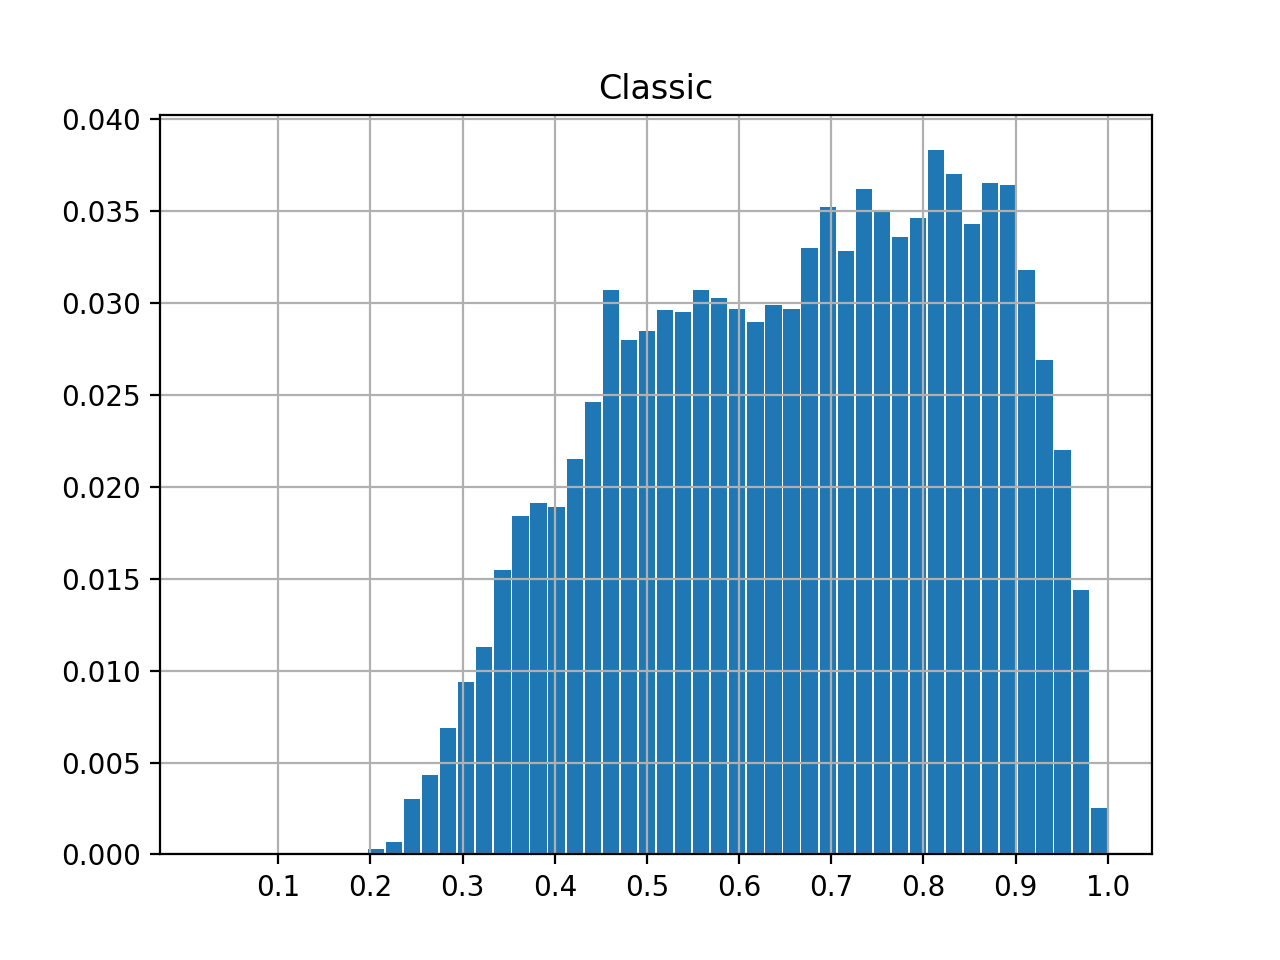

<IPython.core.display.Javascript object>


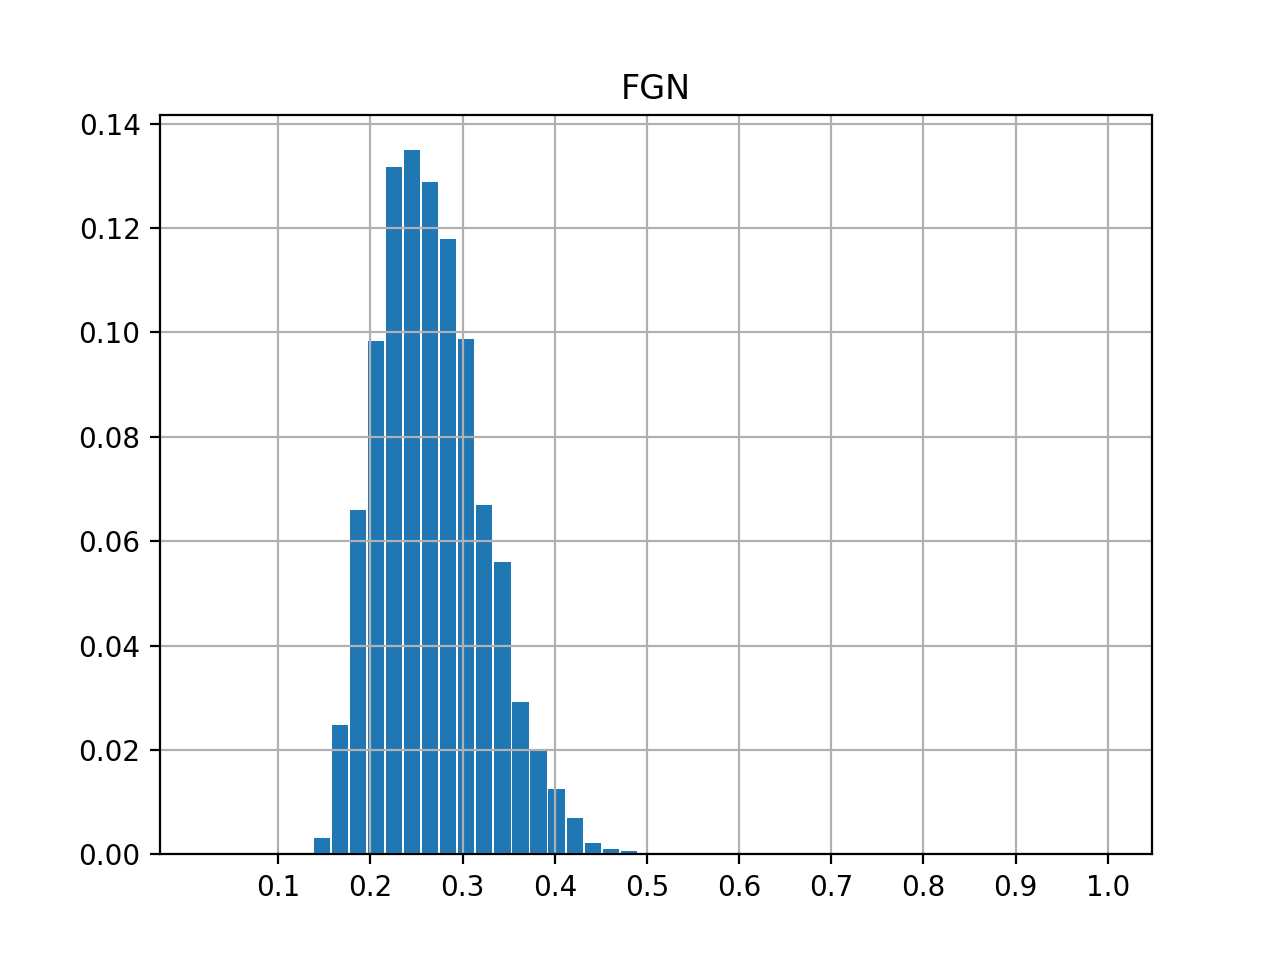

In [40]:
weights = np.ones_like(fgn_maxes_test)/len(fgn_maxes_test)

# classic
plt.hist(classic_maxes_test, bins=(np.arange(51)+1)/51.0, rwidth=0.9, align='mid', weights=weights)
plt.xticks((np.arange(10)+1)/10.0)
plt.grid(True)
plt.title("Classic")
plt.show()

# fgn
plt.hist(fgn_maxes_test, bins=(np.arange(51)+1)/51.0, rwidth=0.9, align='mid', weights=weights)
plt.xticks((np.arange(10)+1)/10.0)
plt.grid(True)
plt.title("FGN")
plt.show()

In [24]:
### part 2, now compare all models
# results will be of the form:
# {model_name_acc: mnist_acc; model__name_pred: preds} with preds being a list with the predictions for each class
results = {}

# for each classical network
for s in network_sizes:
    print("Working on size:", s)
    # for each exp 
    for exp_num in range(12):
        print("Working on exp:", exp_num)
        
        # create classic model
        classic_model = th.Classic_MNIST_Net(hidden_l_nums=s)
        #state dict
        # dict load
        classic_model_path = classic_model_dir+'/model_'+str(s)+'_exp_'+str(exp_num)+'_state_dict.pth'
        print(classic_model_path)
        classic_model.to(device)
        classic_model.load_state_dict(torch.load(classic_model_path))
        print("Classic Model loaded")
        
        # create fgn model
        converted_fgn_model = th.Feedforward_FGN_net(28*28,10,s).to(device)
        #state dict
        # dict load
        converted_fgn_model_path = converted_model_dir+'/fgn_model_'+str(s)+'_exp_'+str(exp_num)+'_state_dict.pth'
        print(converted_fgn_model_path)
        converted_fgn_model.to(device)
        converted_fgn_model.load_state_dict(torch.load(converted_fgn_model_path))
        print("converted FGN Model loaded")
        
        # Check that mnist accuracy is close
        # classic model perf
        classic_test_res = th.test(classic_model, device, mnist_test_loader, loss_func=classic_nll_loss_func, verbose=True, pred_func=classic_pred_func)
        # perf (check that same or close to above)
        fgn_test_res = th.test(converted_fgn_model, device, mnist_test_loader, loss_func=fgn_nll_loss_func, verbose=True, pred_func=fgn_pred_func)
        if fgn_test_res['test_accuracy'] < 0.99*classic_test_res['test_accuracy']:
            print("Error during conversion")
        else:
            print("Conversion successful")
            
        # save the accuracies
        results['model_'+str(s)+'_exp_'+str(exp_num)+'_acc'] = classic_test_res['test_accuracy']
        results['fgn_model_'+str(s)+'_exp_'+str(exp_num)+'_acc'] = fgn_test_res['test_accuracy']
    
        # apply models to random data
        # get classic predictions 
        classic_predictions = np.array([])
        for data in rand_dataloader:
            data = data[0].to(device)
            pred = classic_model(data)
            pred = pred.cpu().detach().numpy()
            try:
                classic_predictions = np.concatenate((classic_predictions,pred))
            except:
                classic_predictions=pred

        # for some reason the networks make log_softmax predictions
        classic_predictions = np.exp(classic_predictions)
        
        # get fgn predictions 
        fgn_predictions = np.array([])
        for data in rand_dataloader:
            data = data[0].to(device)
            pred,_ = converted_fgn_model(data)
            pred = pred.cpu().detach().numpy()
            try:
                fgn_predictions = np.concatenate((fgn_predictions,pred))
            except:
                fgn_predictions=pred

        # for some reason the networks make log_softmax predictions
        fgn_predictions = np.exp(fgn_predictions)

        # save the predictions
        results['model_'+str(s)+'_exp_'+str(exp_num)+'_preds'] = classic_predictions
        results['fgn_model_'+str(s)+'_exp_'+str(exp_num)+'_preds'] = fgn_predictions
        
        

Working on size: []
Working on exp: 0
./saved_models/Classic_MNIST_Nets//model_[]_exp_0_state_dict.pth
Classic Model loaded
./saved_models/Converted_MNIST_Nets//fgn_model_[]_exp_0_state_dict.pth
converted FGN Model loaded
Test set - Average loss: 0.0044, Accuracy: 9198/10000 (92%)
Test set - Average loss: 0.0347, Accuracy: 9192/10000 (92%)
Conversion successful
Working on exp: 1
./saved_models/Classic_MNIST_Nets//model_[]_exp_1_state_dict.pth
Classic Model loaded
./saved_models/Converted_MNIST_Nets//fgn_model_[]_exp_1_state_dict.pth
converted FGN Model loaded
Test set - Average loss: 0.0043, Accuracy: 9212/10000 (92%)
Test set - Average loss: 0.0347, Accuracy: 9184/10000 (92%)
Conversion successful
Working on exp: 2
./saved_models/Classic_MNIST_Nets//model_[]_exp_2_state_dict.pth
Classic Model loaded
./saved_models/Converted_MNIST_Nets//fgn_model_[]_exp_2_state_dict.pth
converted FGN Model loaded
Test set - Average loss: 0.0043, Accuracy: 9213/10000 (92%)
Test set - Average loss: 0.034

Test set - Average loss: 0.0053, Accuracy: 9033/10000 (90%)
Test set - Average loss: 0.0222, Accuracy: 8978/10000 (90%)
Conversion successful
Working on size: [128]
Working on exp: 0
./saved_models/Classic_MNIST_Nets//model_[128]_exp_0_state_dict.pth
Classic Model loaded
./saved_models/Converted_MNIST_Nets//fgn_model_[128]_exp_0_state_dict.pth
converted FGN Model loaded
Test set - Average loss: 0.0019, Accuracy: 9642/10000 (96%)
Test set - Average loss: 0.0248, Accuracy: 9360/10000 (94%)
Error during conversion
Working on exp: 1
./saved_models/Classic_MNIST_Nets//model_[128]_exp_1_state_dict.pth
Classic Model loaded
./saved_models/Converted_MNIST_Nets//fgn_model_[128]_exp_1_state_dict.pth
converted FGN Model loaded
Test set - Average loss: 0.0020, Accuracy: 9623/10000 (96%)
Test set - Average loss: 0.0247, Accuracy: 9339/10000 (93%)
Error during conversion
Working on exp: 2
./saved_models/Classic_MNIST_Nets//model_[128]_exp_2_state_dict.pth
Classic Model loaded
./saved_models/Converted

Test set - Average loss: 0.0027, Accuracy: 9562/10000 (96%)
Conversion successful
Working on exp: 11
./saved_models/Classic_MNIST_Nets//model_[1024]_exp_11_state_dict.pth
Classic Model loaded
./saved_models/Converted_MNIST_Nets//fgn_model_[1024]_exp_11_state_dict.pth
converted FGN Model loaded
Test set - Average loss: 0.0020, Accuracy: 9632/10000 (96%)
Test set - Average loss: 0.0027, Accuracy: 9562/10000 (96%)
Conversion successful
Working on size: [8, 8]
Working on exp: 0
./saved_models/Classic_MNIST_Nets//model_[8, 8]_exp_0_state_dict.pth
Classic Model loaded
./saved_models/Converted_MNIST_Nets//fgn_model_[8, 8]_exp_0_state_dict.pth
converted FGN Model loaded
Test set - Average loss: 0.0056, Accuracy: 9047/10000 (90%)
Test set - Average loss: 0.0181, Accuracy: 8944/10000 (89%)
Error during conversion
Working on exp: 1
./saved_models/Classic_MNIST_Nets//model_[8, 8]_exp_1_state_dict.pth
Classic Model loaded
./saved_models/Converted_MNIST_Nets//fgn_model_[8, 8]_exp_1_state_dict.pth
co

Test set - Average loss: 0.0016, Accuracy: 9676/10000 (97%)
Test set - Average loss: 0.0223, Accuracy: 9350/10000 (94%)
Error during conversion
Working on exp: 10
./saved_models/Classic_MNIST_Nets//model_[128, 128]_exp_10_state_dict.pth
Classic Model loaded
./saved_models/Converted_MNIST_Nets//fgn_model_[128, 128]_exp_10_state_dict.pth
converted FGN Model loaded
Test set - Average loss: 0.0016, Accuracy: 9684/10000 (97%)
Test set - Average loss: 0.0220, Accuracy: 9323/10000 (93%)
Error during conversion
Working on exp: 11
./saved_models/Classic_MNIST_Nets//model_[128, 128]_exp_11_state_dict.pth
Classic Model loaded
./saved_models/Converted_MNIST_Nets//fgn_model_[128, 128]_exp_11_state_dict.pth
converted FGN Model loaded
Test set - Average loss: 0.0017, Accuracy: 9679/10000 (97%)
Test set - Average loss: 0.0079, Accuracy: 9634/10000 (96%)
Conversion successful
Working on size: [1024, 1024]
Working on exp: 0
./saved_models/Classic_MNIST_Nets//model_[1024, 1024]_exp_0_state_dict.pth
Class

Test set - Average loss: 0.0068, Accuracy: 8794/10000 (88%)
Test set - Average loss: 0.0182, Accuracy: 8660/10000 (87%)
Error during conversion
Working on exp: 9
./saved_models/Classic_MNIST_Nets//model_[8, 8, 8]_exp_9_state_dict.pth
Classic Model loaded
./saved_models/Converted_MNIST_Nets//fgn_model_[8, 8, 8]_exp_9_state_dict.pth
converted FGN Model loaded
Test set - Average loss: 0.0071, Accuracy: 8893/10000 (89%)
Test set - Average loss: 0.0097, Accuracy: 8882/10000 (89%)
Conversion successful
Working on exp: 10
./saved_models/Classic_MNIST_Nets//model_[8, 8, 8]_exp_10_state_dict.pth
Classic Model loaded
./saved_models/Converted_MNIST_Nets//fgn_model_[8, 8, 8]_exp_10_state_dict.pth
converted FGN Model loaded
Test set - Average loss: 0.0066, Accuracy: 8850/10000 (88%)
Test set - Average loss: 0.0086, Accuracy: 8813/10000 (88%)
Conversion successful
Working on exp: 11
./saved_models/Classic_MNIST_Nets//model_[8, 8, 8]_exp_11_state_dict.pth
Classic Model loaded
./saved_models/Converted

Test set - Average loss: 0.0018, Accuracy: 9658/10000 (97%)
Test set - Average loss: 0.0023, Accuracy: 9591/10000 (96%)
Conversion successful
Working on exp: 7
./saved_models/Classic_MNIST_Nets//model_[1024, 1024, 1024]_exp_7_state_dict.pth
Classic Model loaded
./saved_models/Converted_MNIST_Nets//fgn_model_[1024, 1024, 1024]_exp_7_state_dict.pth
converted FGN Model loaded
Test set - Average loss: 0.0017, Accuracy: 9674/10000 (97%)
Test set - Average loss: 0.0021, Accuracy: 9640/10000 (96%)
Conversion successful
Working on exp: 8
./saved_models/Classic_MNIST_Nets//model_[1024, 1024, 1024]_exp_8_state_dict.pth
Classic Model loaded
./saved_models/Converted_MNIST_Nets//fgn_model_[1024, 1024, 1024]_exp_8_state_dict.pth
converted FGN Model loaded
Test set - Average loss: 0.0017, Accuracy: 9672/10000 (97%)
Test set - Average loss: 0.0022, Accuracy: 9595/10000 (96%)
Conversion successful
Working on exp: 9
./saved_models/Classic_MNIST_Nets//model_[1024, 1024, 1024]_exp_9_state_dict.pth
Classic

In [42]:
# save results pickle
import pickle

In [25]:
pickle.dump( results, open( "./2.2.3b-results-dict.pckl", "wb" ) )

In [43]:
# load results pickle
results = pickle.load( open("./2.2.3b-results-dict.pckl", "rb" ) )

<IPython.core.display.Javascript object>


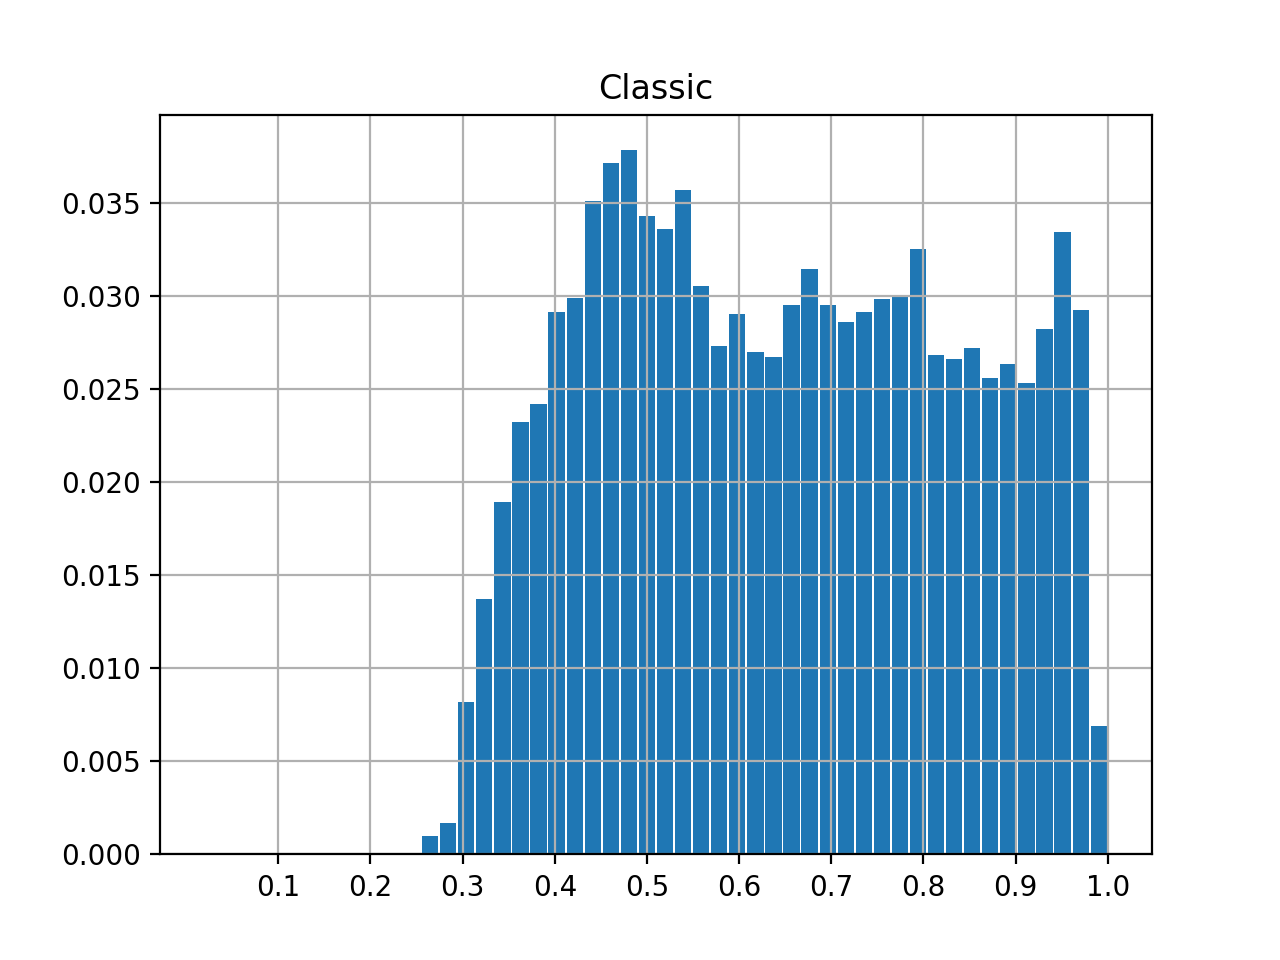

<IPython.core.display.Javascript object>


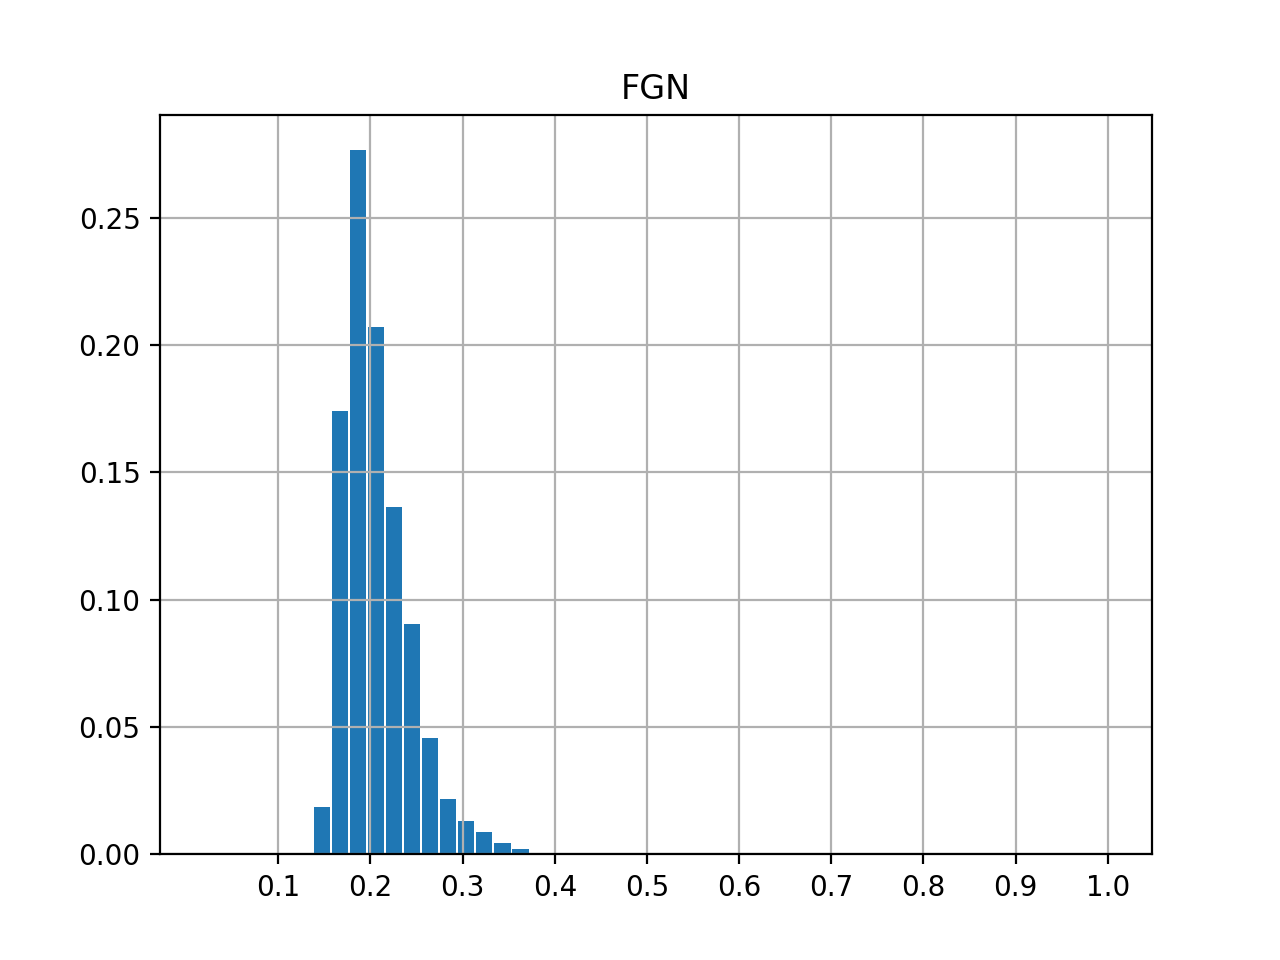

In [45]:
# we only care about the max of the preds
classic_maxes_test = [np.max(p) for p in results['model_[8]_exp_0_preds']]
fgn_maxes_test = [np.max(p) for p in results['fgn_model_[8]_exp_0_preds']]

weights = np.ones_like(fgn_maxes_test)/len(fgn_maxes_test)

# classic
plt.hist(classic_maxes_test, bins=(np.arange(51)+1)/51.0, rwidth=0.9, align='mid', weights=weights)
plt.xticks((np.arange(10)+1)/10.0)
plt.grid(True)
plt.title("Classic")
plt.show()

# fgn
plt.hist(fgn_maxes_test, bins=(np.arange(51)+1)/51.0, rwidth=0.9, align='mid', weights=weights)
plt.xticks((np.arange(10)+1)/10.0)
plt.grid(True)
plt.title("FGN")
plt.show()

Network size []
91.98 vs 91.92
92.12 vs 91.84
92.13 vs 91.83
92.32 vs 92.01
91.96 vs 91.41
92.02 vs 91.47
92.21 vs 91.74
92.16 vs 91.46
91.91 vs 91.93
92.07 vs 92.04
92.21 vs 92.15
92.11 vs 91.28


<IPython.core.display.Javascript object>


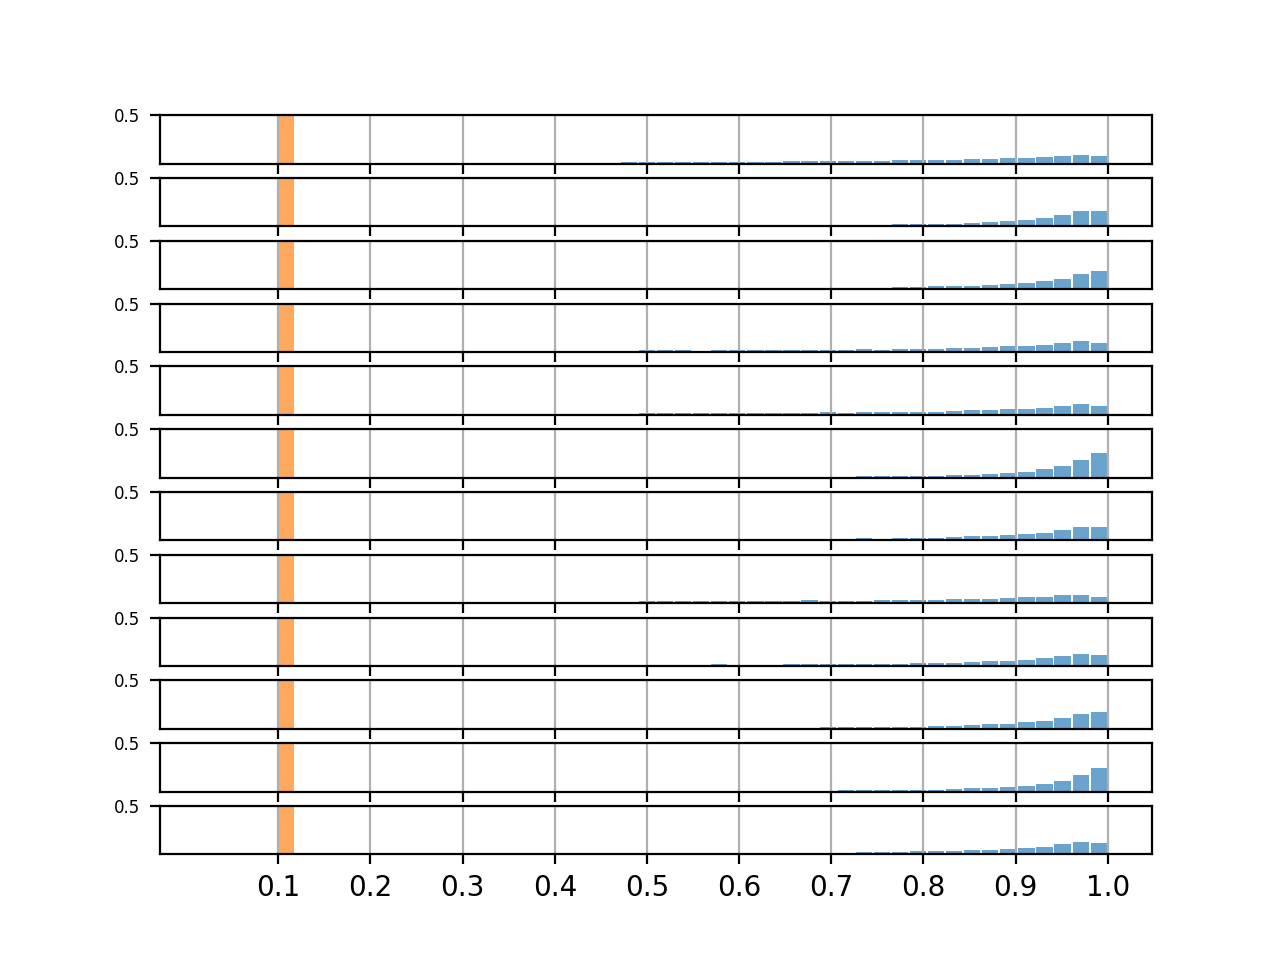

Network size [8]
90.53 vs 90.36
90.71 vs 90.64
89.74 vs 89.24
89.95 vs 89.05
90.57 vs 86.86
90.07 vs 90.1
90.3 vs 90.07
89.44 vs 88.37
89.34 vs 88.88
90.32 vs 89.79
90.12 vs 86.38
90.33 vs 89.78


<IPython.core.display.Javascript object>


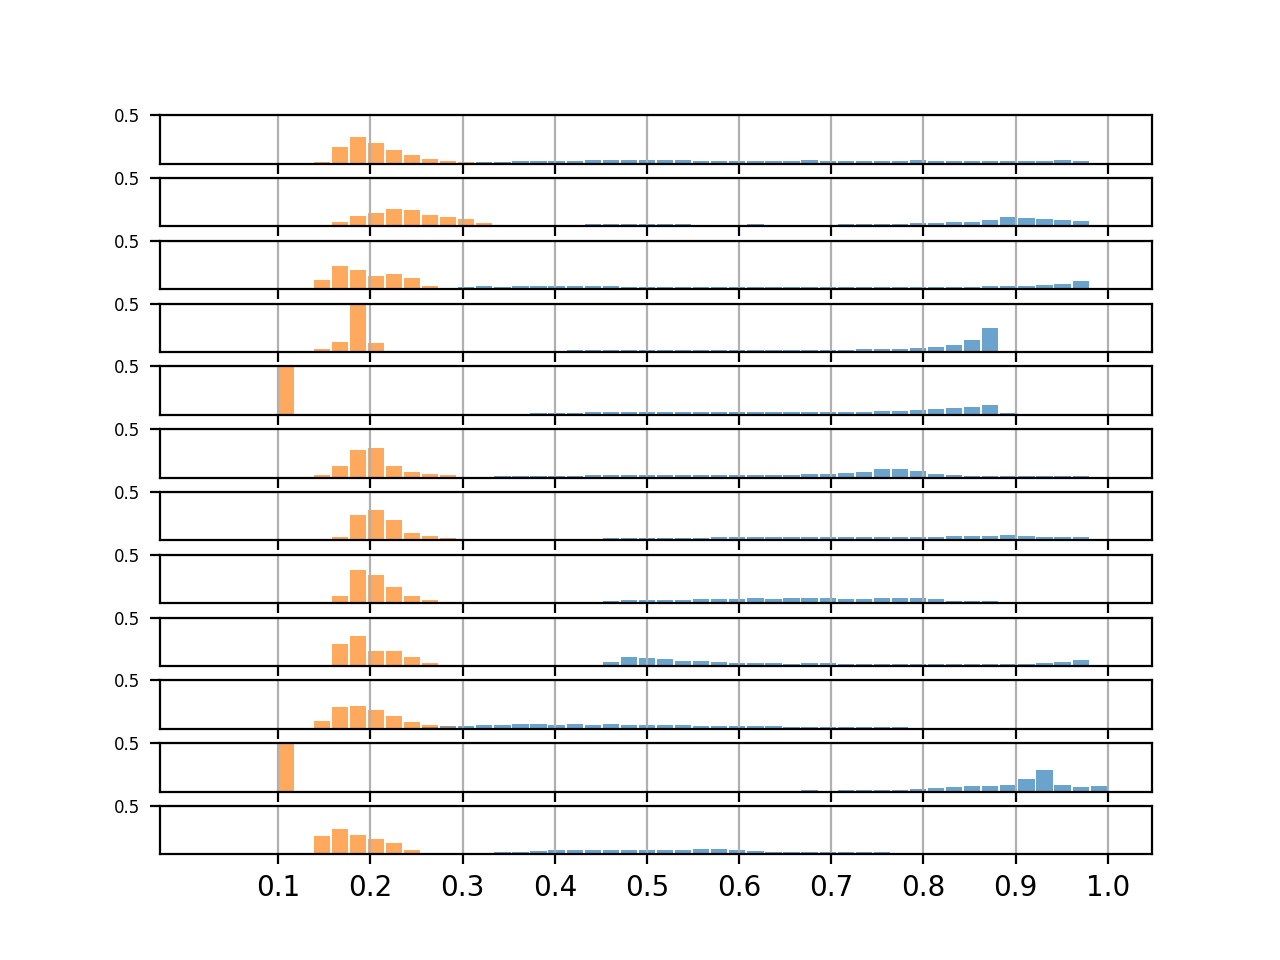

Network size [128]
96.42 vs 93.6
96.23 vs 93.39
96.41 vs 93.85
96.34 vs 93.75
96.22 vs 93.5
96.32 vs 93.76
96.35 vs 93.93
96.21 vs 93.62
95.97 vs 93.63
96.41 vs 93.46
96.4 vs 93.78
96.25 vs 93.51


<IPython.core.display.Javascript object>


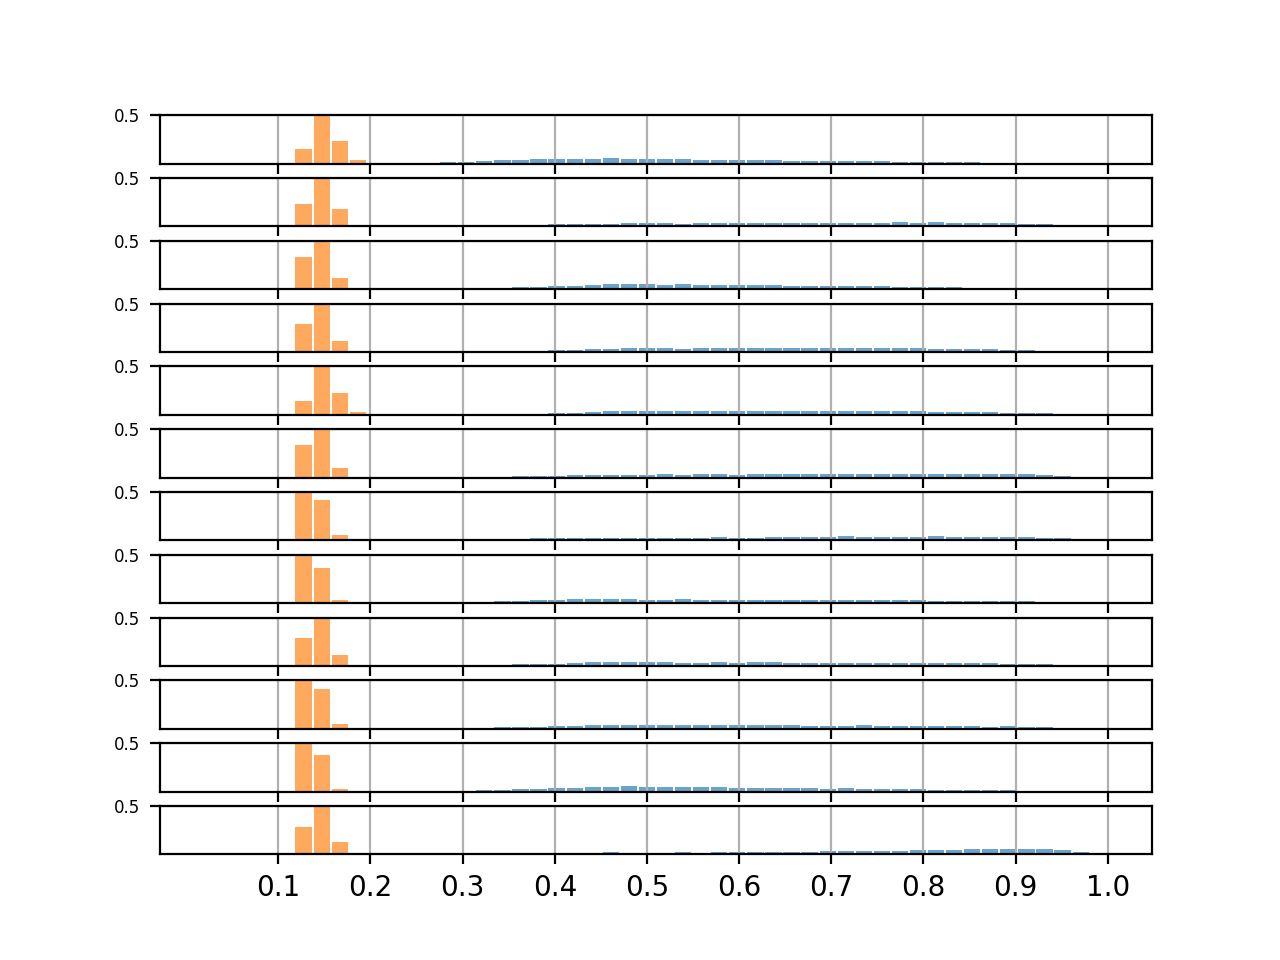

Network size [1024]
96.25 vs 95.5
96.16 vs 91.63
96.51 vs 95.78
96.31 vs 95.52
96.25 vs 92.4
96.49 vs 91.99
96.34 vs 91.71
96.23 vs 95.56
96.47 vs 91.72
96.25 vs 91.45
96.42 vs 95.62
96.32 vs 95.62


<IPython.core.display.Javascript object>


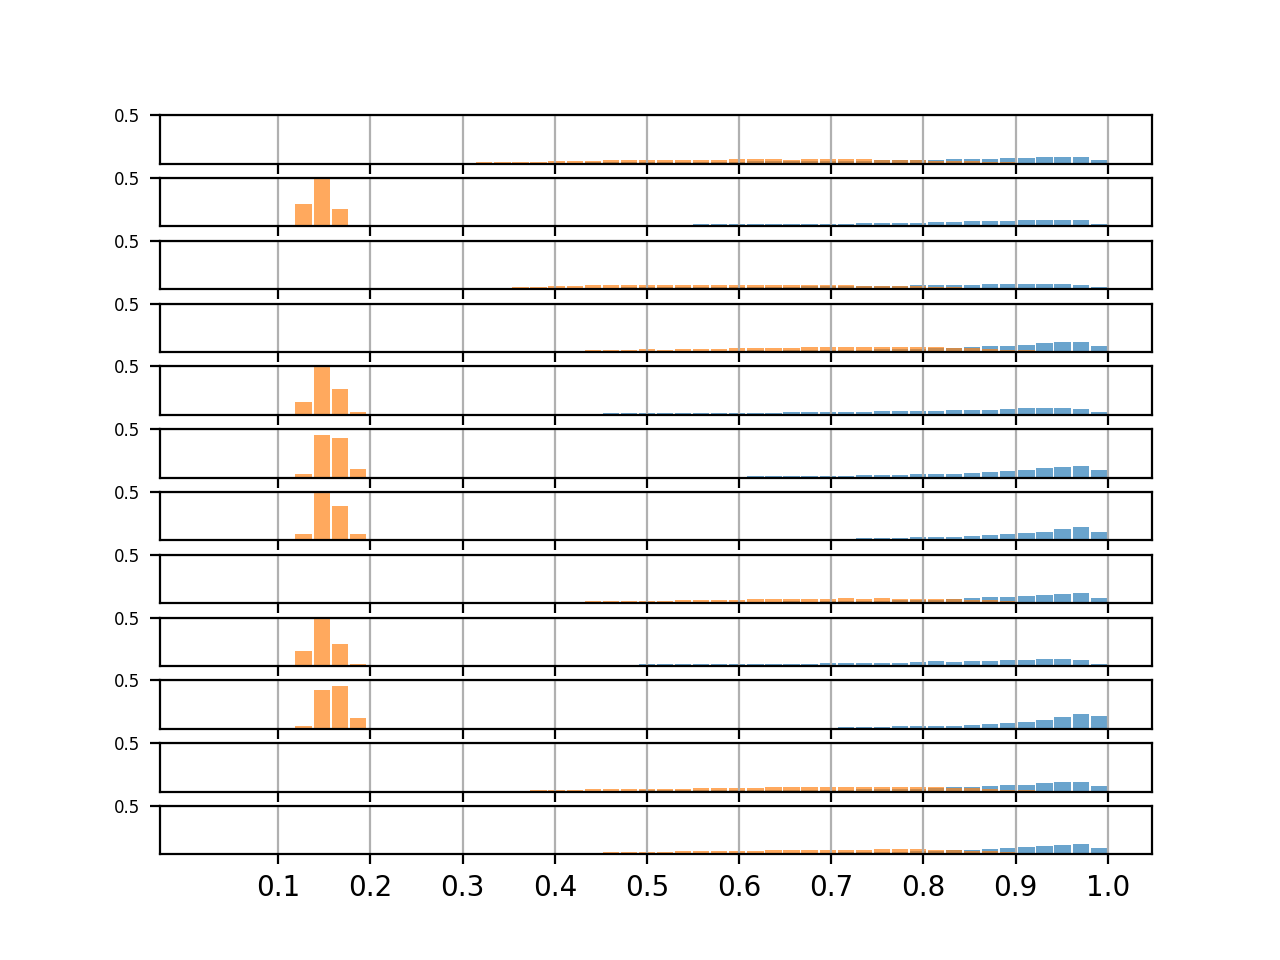

Network size [8, 8]
90.47 vs 89.44
89.68 vs 89.22
90.08 vs 89.9
88.85 vs 87.99
90.03 vs 89.5
90.52 vs 90.17
90.45 vs 89.86
88.46 vs 87.65
90.16 vs 89.29
90.29 vs 90.24
90.09 vs 89.72
90.39 vs 89.53


<IPython.core.display.Javascript object>


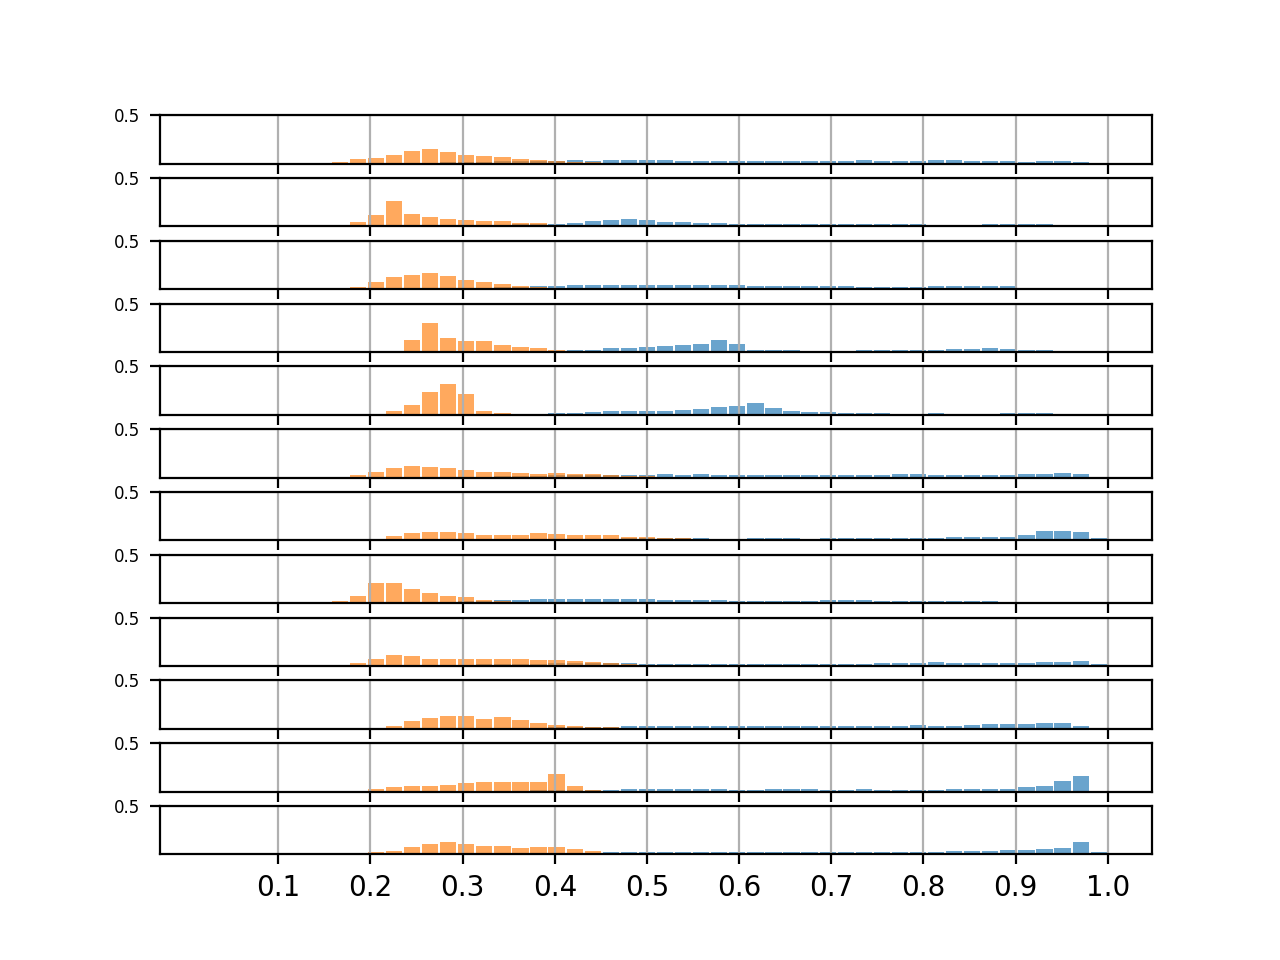

Network size [128, 128]
96.81 vs 93.49
96.79 vs 92.58
96.83 vs 93.45
96.82 vs 93.69
96.84 vs 92.77
96.72 vs 93.39
96.78 vs 93.09
96.96 vs 92.76
96.74 vs 92.95
96.76 vs 93.5
96.84 vs 93.23
96.79 vs 96.34


<IPython.core.display.Javascript object>


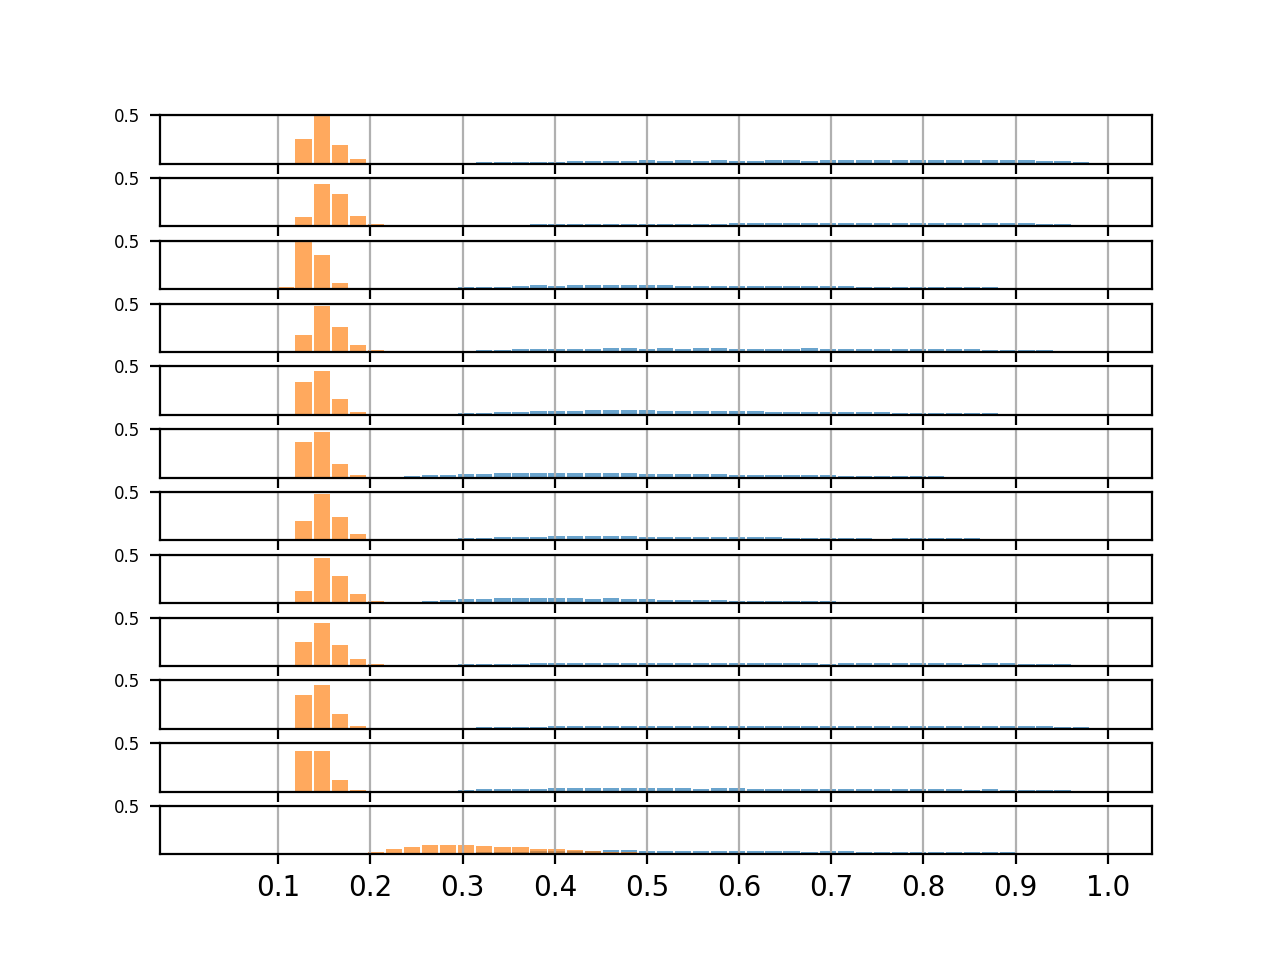

Network size [1024, 1024]
96.41 vs 95.93
96.7 vs 95.86
96.78 vs 96.07
96.68 vs 92.15
96.48 vs 95.53
96.7 vs 96.01
96.49 vs 95.46
96.85 vs 96.21
96.82 vs 96.03
96.62 vs 95.89
96.65 vs 96.09
96.6 vs 96.0


<IPython.core.display.Javascript object>


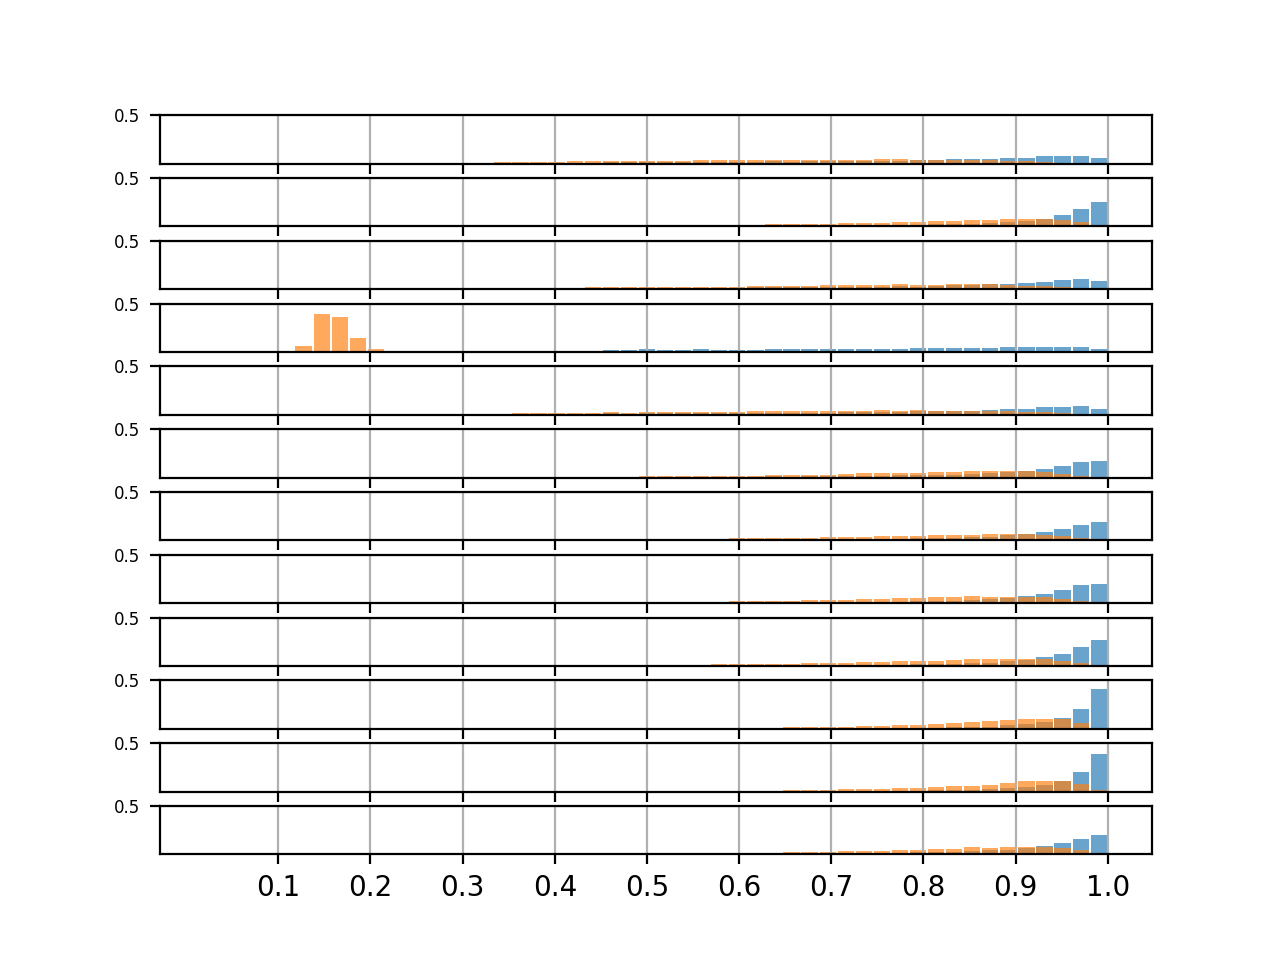

Network size [8, 8, 8]
89.43 vs 88.69
89.87 vs 89.69
90.37 vs 88.32
89.06 vs 88.71
89.53 vs 88.33
88.52 vs 84.23
88.95 vs 87.03
89.46 vs 87.13
87.94 vs 86.6
88.93 vs 88.82
88.5 vs 88.13
89.76 vs 87.97


<IPython.core.display.Javascript object>


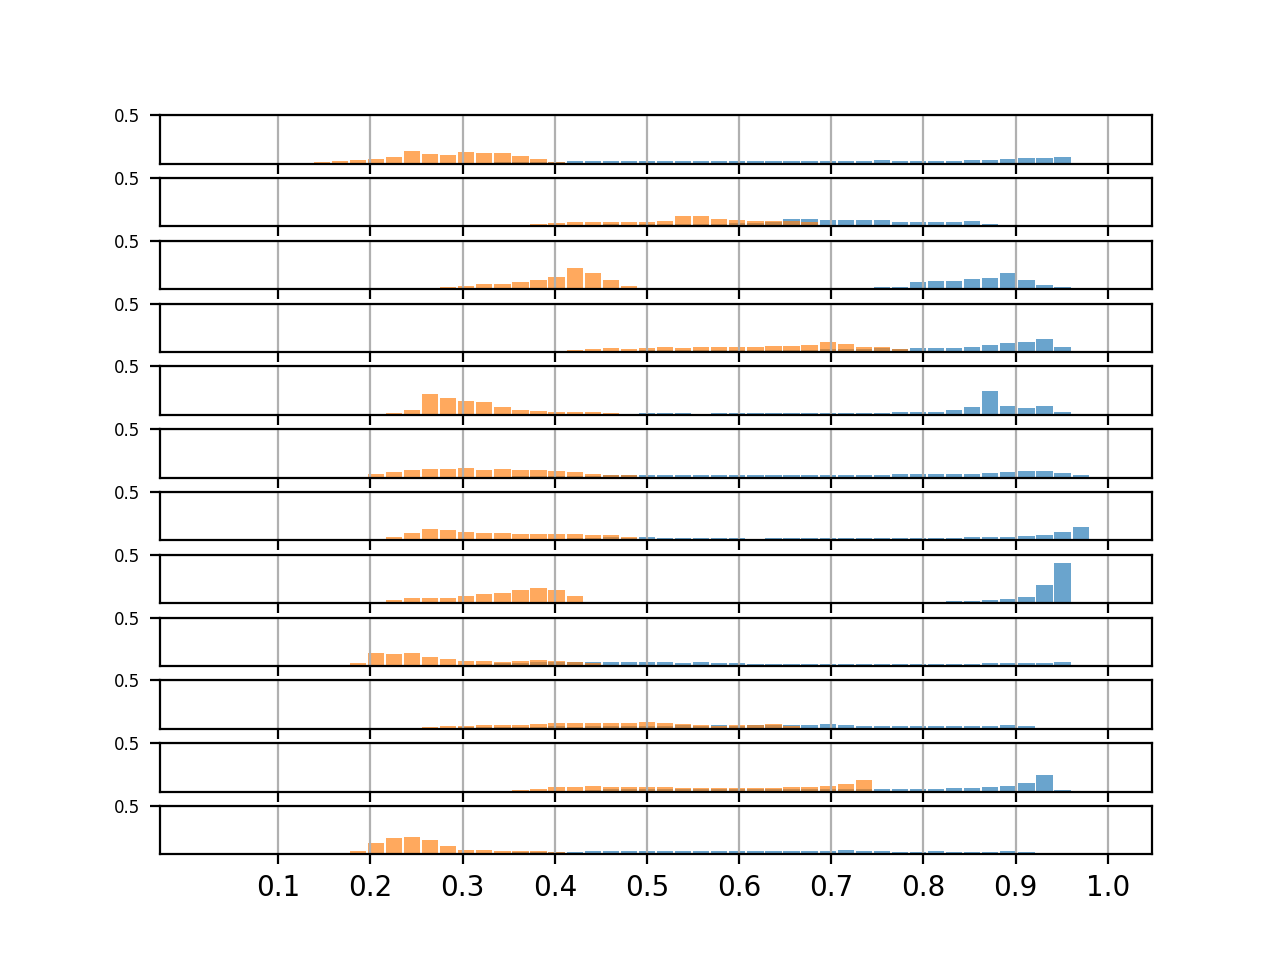

Network size [128, 128, 128]
97.03 vs 96.65
97.14 vs 96.67
97.24 vs 97.13
97.19 vs 96.91
97.09 vs 96.75
97.09 vs 96.76
97.08 vs 96.72
97.09 vs 96.69
97.27 vs 96.89
97.26 vs 96.98
97.23 vs 96.77
97.08 vs 96.72


<IPython.core.display.Javascript object>


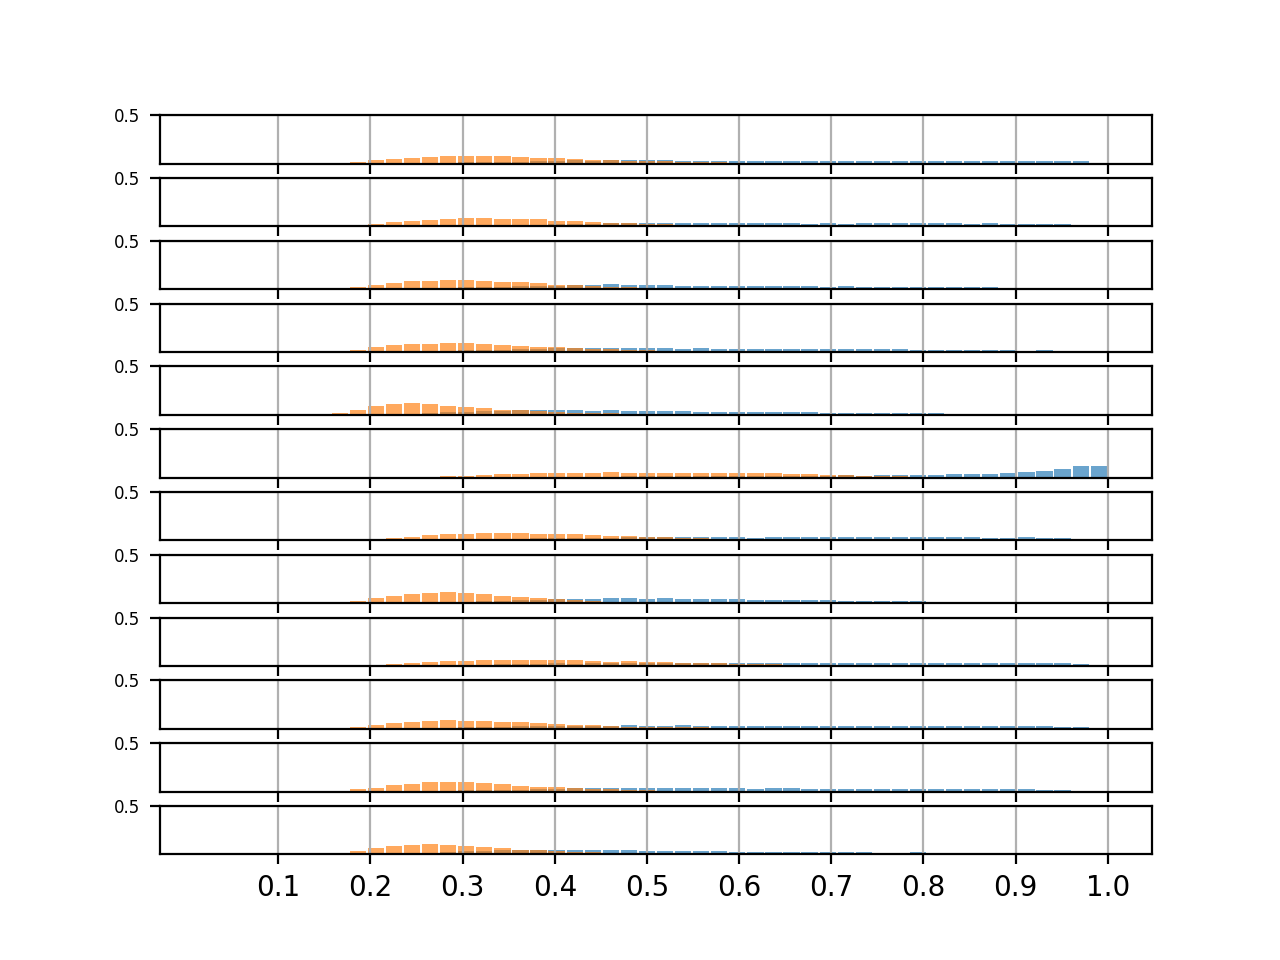

Network size [1024, 1024, 1024]
96.99 vs 96.41
96.5 vs 95.69
96.85 vs 96.36
96.96 vs 96.45
96.54 vs 95.41
96.68 vs 96.1
96.58 vs 95.91
96.74 vs 96.4
96.72 vs 95.95
96.88 vs 96.42
96.95 vs 96.38
96.83 vs 96.2


<IPython.core.display.Javascript object>


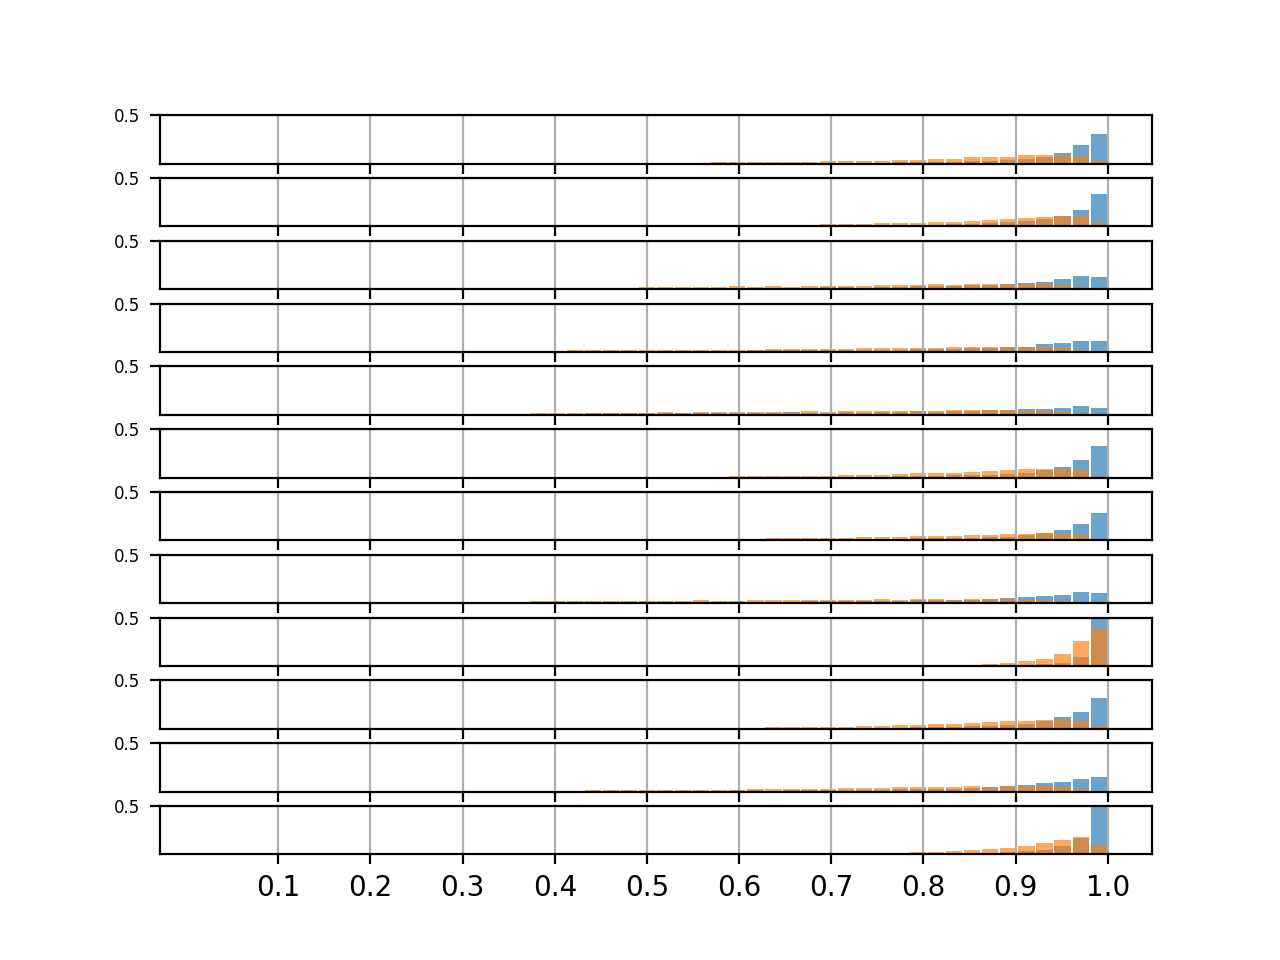

In [98]:
# plot the histogram for each model

for size in network_sizes:
    print("Network size", size)
    subplot_num = 0
    for exp_num in range(12):
#         print("Exp Num", exp_num)
        
        classic_model_name = 'model_'+str(size)+'_exp_'+str(exp_num)
        fgn_model_name = 'fgn_model_'+str(size)+'_exp_'+str(exp_num)
        
        classic_acc = results[classic_model_name+'_acc']
        fgn_acc = results[fgn_model_name+'_acc']
        print(classic_acc, 'vs', fgn_acc)
        
        # we only care about the max of the preds
        classic_maxes = [np.max(p) for p in results[classic_model_name+'_preds']]
        fgn_maxes = [np.max(p) for p in results[fgn_model_name+'_preds']]
        
        subplot_num += 1
        axe = plt.subplot(12,1, subplot_num)
        axe.hist(classic_maxes, bins=(np.arange(51)+1)/51.0, rwidth=0.9, align='mid', weights=weights, alpha=0.665)
        axe.hist(fgn_maxes, bins=(np.arange(51)+1)/51.0, rwidth=0.9, align='mid', weights=weights, alpha=0.665)
        plt.xticks((np.arange(10)+1)/10.0)
        if exp_num != 11: plt.setp(axe.get_xticklabels(), visible=False)
        plt.yticks([0.5], fontsize=6)
        axe.set_ylim([0,0.5])
        plt.grid(True)
        
    plt.subplots_adjust( hspace=0.3)
    plt.show()

In [1]:
### part 3 : how do the converted nets perform over MNIST, not in accuracy but in histogram?


In [47]:
# results will be of the form:
# {model_name_acc: mnist_acc; model__name_pred: preds} with preds being a list with the predictions for each class
results_over_mnist = {}

# for each classical network
for s in network_sizes:
    print("Working on size:", s)
    # for each exp 
    for exp_num in range(12):
        print("Working on exp:", exp_num)
        
        # create classic model
        classic_model = th.Classic_MNIST_Net(hidden_l_nums=s)
        #state dict
        # dict load
        classic_model_path = classic_model_dir+'/model_'+str(s)+'_exp_'+str(exp_num)+'_state_dict.pth'
        print(classic_model_path)
        classic_model.to(device)
        classic_model.load_state_dict(torch.load(classic_model_path))
        print("Classic Model loaded")
        
        # create fgn model
        converted_fgn_model = th.Feedforward_FGN_net(28*28,10,s).to(device)
        #state dict
        # dict load
        converted_fgn_model_path = converted_model_dir+'/fgn_model_'+str(s)+'_exp_'+str(exp_num)+'_state_dict.pth'
        print(converted_fgn_model_path)
        converted_fgn_model.to(device)
        converted_fgn_model.load_state_dict(torch.load(converted_fgn_model_path))
        print("converted FGN Model loaded")
        
        # Check that mnist accuracy is close
        # classic model perf
        classic_test_res = th.test(classic_model, device, mnist_test_loader, loss_func=classic_nll_loss_func, verbose=True, pred_func=classic_pred_func)
        # perf (check that same or close to above)
        fgn_test_res = th.test(converted_fgn_model, device, mnist_test_loader, loss_func=fgn_nll_loss_func, verbose=True, pred_func=fgn_pred_func)
        if fgn_test_res['test_accuracy'] < 0.95*classic_test_res['test_accuracy']:
            print("Error during conversion")
        else:
            print("Conversion successful")
            
        # save the accuracies (not needed, already saved above)
        results_over_mnist['model_'+str(s)+'_exp_'+str(exp_num)+'_acc'] = classic_test_res['test_accuracy']
        results_over_mnist['fgn_model_'+str(s)+'_exp_'+str(exp_num)+'_acc'] = fgn_test_res['test_accuracy']
    
        # apply models to MNIST data
        # get classic predictions 
        classic_predictions = np.array([])
        for data in mnist_train_loader:
            data = data[0].to(device)
            pred = classic_model(data)
            pred = pred.cpu().detach().numpy()
            try:
                classic_predictions = np.concatenate((classic_predictions,pred))
            except:
                classic_predictions=pred

        # for some reason the networks make log_softmax predictions
        classic_predictions = np.exp(classic_predictions)
        
        # get fgn predictions 
        fgn_predictions = np.array([])
        for data in mnist_train_loader:
            data = data[0].to(device)
            pred = converted_fgn_model(data)
            pred = pred.cpu().detach().numpy()
            try:
                fgn_predictions = np.concatenate((fgn_predictions,pred))
            except:
                fgn_predictions=pred

        # for some reason the networks make log_softmax predictions
        fgn_predictions = np.exp(fgn_predictions)

        # save the predictions
        results_over_mnist['model_'+str(s)+'_exp_'+str(exp_num)+'_preds'] = classic_predictions
        results_over_mnist['fgn_model_'+str(s)+'_exp_'+str(exp_num)+'_preds'] = fgn_predictions
        
        

Working on size: []
Working on exp: 0
./saved_models/Classic_MNIST_Nets//model_[]_exp_0_state_dict.pth
Classic Model loaded
./saved_models/Converted_MNIST_Nets//fgn_model_[]_exp_0_state_dict.pth
converted FGN Model loaded
Test set - Average loss: 0.2787, Accuracy: 9198/10000 (92%)
Test set - Average loss: 2.0733, Accuracy: 9212/10000 (92%)
Conversion successful
Working on exp: 1
./saved_models/Classic_MNIST_Nets//model_[]_exp_1_state_dict.pth
Classic Model loaded
./saved_models/Converted_MNIST_Nets//fgn_model_[]_exp_1_state_dict.pth
converted FGN Model loaded
Test set - Average loss: 0.2776, Accuracy: 9212/10000 (92%)
Test set - Average loss: 2.0695, Accuracy: 9189/10000 (92%)
Conversion successful
Working on exp: 2
./saved_models/Classic_MNIST_Nets//model_[]_exp_2_state_dict.pth
Classic Model loaded
./saved_models/Converted_MNIST_Nets//fgn_model_[]_exp_2_state_dict.pth
converted FGN Model loaded
Test set - Average loss: 0.2746, Accuracy: 9213/10000 (92%)
Test set - Average loss: 2.069

Test set - Average loss: 2.2971, Accuracy: 8728/10000 (87%)
Conversion successful
Working on size: [128]
Working on exp: 0
./saved_models/Classic_MNIST_Nets//model_[128]_exp_0_state_dict.pth
Classic Model loaded
./saved_models/Converted_MNIST_Nets//fgn_model_[128]_exp_0_state_dict.pth
converted FGN Model loaded
Test set - Average loss: 0.1244, Accuracy: 9642/10000 (96%)
Test set - Average loss: 2.2026, Accuracy: 9471/10000 (95%)
Conversion successful
Working on exp: 1
./saved_models/Classic_MNIST_Nets//model_[128]_exp_1_state_dict.pth
Classic Model loaded
./saved_models/Converted_MNIST_Nets//fgn_model_[128]_exp_1_state_dict.pth
converted FGN Model loaded
Test set - Average loss: 0.1285, Accuracy: 9623/10000 (96%)
Test set - Average loss: 2.2014, Accuracy: 9454/10000 (95%)
Conversion successful
Working on exp: 2
./saved_models/Classic_MNIST_Nets//model_[128]_exp_2_state_dict.pth
Classic Model loaded
./saved_models/Converted_MNIST_Nets//fgn_model_[128]_exp_2_state_dict.pth
converted FGN 

Working on exp: 11
./saved_models/Classic_MNIST_Nets//model_[1024]_exp_11_state_dict.pth
Classic Model loaded
./saved_models/Converted_MNIST_Nets//fgn_model_[1024]_exp_11_state_dict.pth
converted FGN Model loaded
Test set - Average loss: 0.1268, Accuracy: 9632/10000 (96%)
Test set - Average loss: 0.4670, Accuracy: 9298/10000 (93%)
Conversion successful
Working on size: [8, 8]
Working on exp: 0
./saved_models/Classic_MNIST_Nets//model_[8, 8]_exp_0_state_dict.pth
Classic Model loaded
./saved_models/Converted_MNIST_Nets//fgn_model_[8, 8]_exp_0_state_dict.pth
converted FGN Model loaded
Test set - Average loss: 0.3536, Accuracy: 9047/10000 (90%)
Test set - Average loss: 1.4308, Accuracy: 8932/10000 (89%)
Conversion successful
Working on exp: 1
./saved_models/Classic_MNIST_Nets//model_[8, 8]_exp_1_state_dict.pth
Classic Model loaded
./saved_models/Converted_MNIST_Nets//fgn_model_[8, 8]_exp_1_state_dict.pth
converted FGN Model loaded
Test set - Average loss: 0.3723, Accuracy: 8968/10000 (90%)

Working on exp: 10
./saved_models/Classic_MNIST_Nets//model_[128, 128]_exp_10_state_dict.pth
Classic Model loaded
./saved_models/Converted_MNIST_Nets//fgn_model_[128, 128]_exp_10_state_dict.pth
converted FGN Model loaded
Test set - Average loss: 0.1041, Accuracy: 9684/10000 (97%)
Test set - Average loss: 0.8834, Accuracy: 9664/10000 (97%)
Conversion successful
Working on exp: 11
./saved_models/Classic_MNIST_Nets//model_[128, 128]_exp_11_state_dict.pth
Classic Model loaded
./saved_models/Converted_MNIST_Nets//fgn_model_[128, 128]_exp_11_state_dict.pth
converted FGN Model loaded
Test set - Average loss: 0.1085, Accuracy: 9679/10000 (97%)
Test set - Average loss: 0.9058, Accuracy: 9635/10000 (96%)
Conversion successful
Working on size: [1024, 1024]
Working on exp: 0
./saved_models/Classic_MNIST_Nets//model_[1024, 1024]_exp_0_state_dict.pth
Classic Model loaded
./saved_models/Converted_MNIST_Nets//fgn_model_[1024, 1024]_exp_0_state_dict.pth
converted FGN Model loaded
Test set - Average los

Test set - Average loss: 0.4347, Accuracy: 8794/10000 (88%)
Test set - Average loss: 1.5043, Accuracy: 8591/10000 (86%)
Conversion successful
Working on exp: 9
./saved_models/Classic_MNIST_Nets//model_[8, 8, 8]_exp_9_state_dict.pth
Classic Model loaded
./saved_models/Converted_MNIST_Nets//fgn_model_[8, 8, 8]_exp_9_state_dict.pth
converted FGN Model loaded
Test set - Average loss: 0.4503, Accuracy: 8893/10000 (89%)
Test set - Average loss: 0.6844, Accuracy: 8880/10000 (89%)
Conversion successful
Working on exp: 10
./saved_models/Classic_MNIST_Nets//model_[8, 8, 8]_exp_10_state_dict.pth
Classic Model loaded
./saved_models/Converted_MNIST_Nets//fgn_model_[8, 8, 8]_exp_10_state_dict.pth
converted FGN Model loaded
Test set - Average loss: 0.4216, Accuracy: 8850/10000 (88%)
Test set - Average loss: 0.6073, Accuracy: 8815/10000 (88%)
Conversion successful
Working on exp: 11
./saved_models/Classic_MNIST_Nets//model_[8, 8, 8]_exp_11_state_dict.pth
Classic Model loaded
./saved_models/Converted_M

Test set - Average loss: 0.1127, Accuracy: 9658/10000 (97%)
Test set - Average loss: 0.1436, Accuracy: 9617/10000 (96%)
Conversion successful
Working on exp: 7
./saved_models/Classic_MNIST_Nets//model_[1024, 1024, 1024]_exp_7_state_dict.pth
Classic Model loaded
./saved_models/Converted_MNIST_Nets//fgn_model_[1024, 1024, 1024]_exp_7_state_dict.pth
converted FGN Model loaded
Test set - Average loss: 0.1066, Accuracy: 9674/10000 (97%)
Test set - Average loss: 0.4709, Accuracy: 9191/10000 (92%)
Conversion successful
Working on exp: 8
./saved_models/Classic_MNIST_Nets//model_[1024, 1024, 1024]_exp_8_state_dict.pth
Classic Model loaded
./saved_models/Converted_MNIST_Nets//fgn_model_[1024, 1024, 1024]_exp_8_state_dict.pth
converted FGN Model loaded
Test set - Average loss: 0.1088, Accuracy: 9672/10000 (97%)
Test set - Average loss: 0.1349, Accuracy: 9625/10000 (96%)
Conversion successful
Working on exp: 9
./saved_models/Classic_MNIST_Nets//model_[1024, 1024, 1024]_exp_9_state_dict.pth
Classic

In [49]:
# save results pickle
pickle.dump( results_over_mnist, open( "./2.2.3b-results_over_mnist-dict.pckl", "wb" ) )

In [ ]:
# load results pickle
# results_over_mnist = pickle.load( open("./2.2.3b-results_over_mnist-dict.pckl", "rb" ) )

<IPython.core.display.Javascript object>


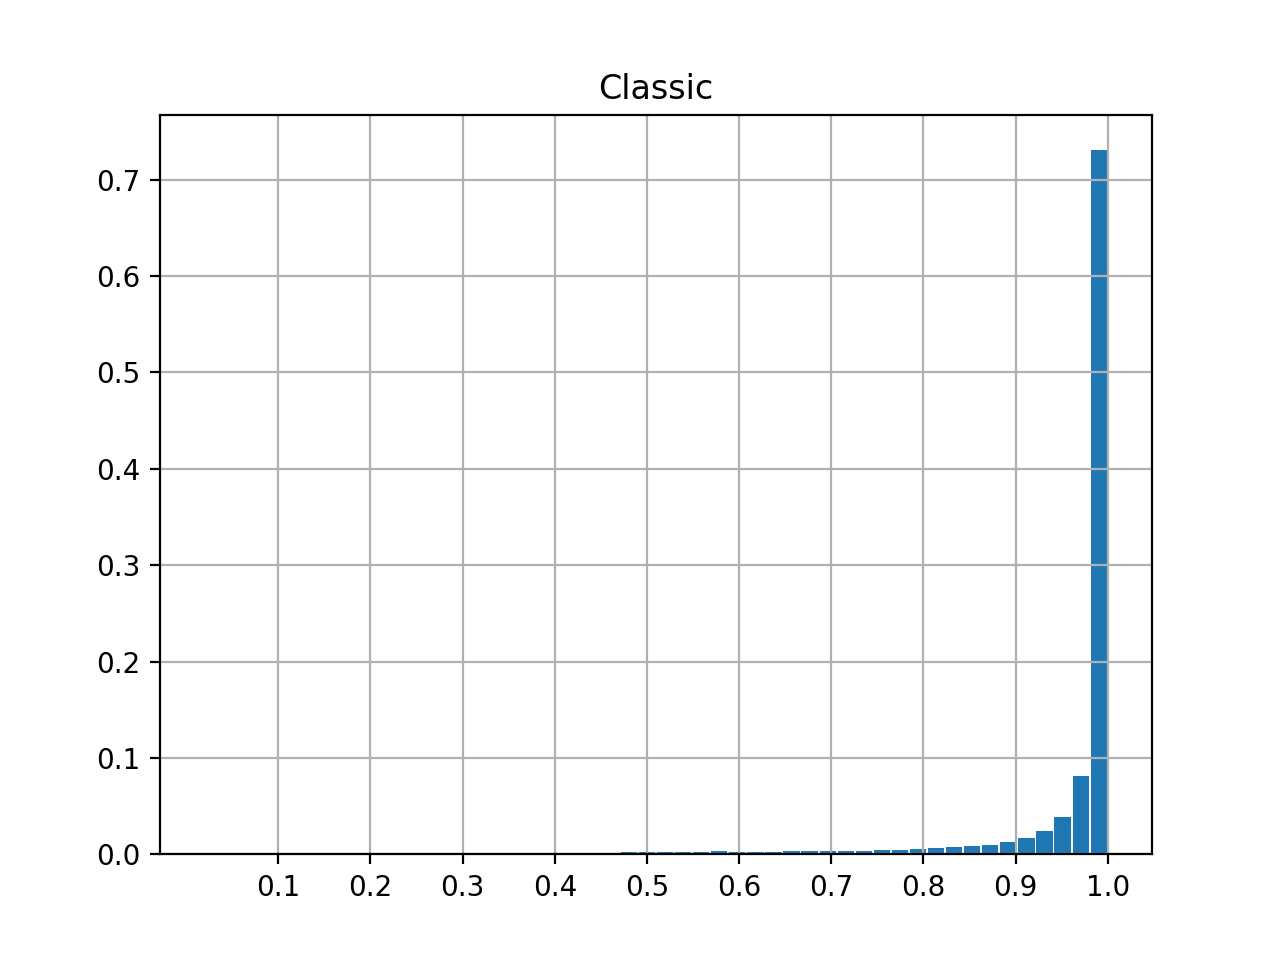

<IPython.core.display.Javascript object>


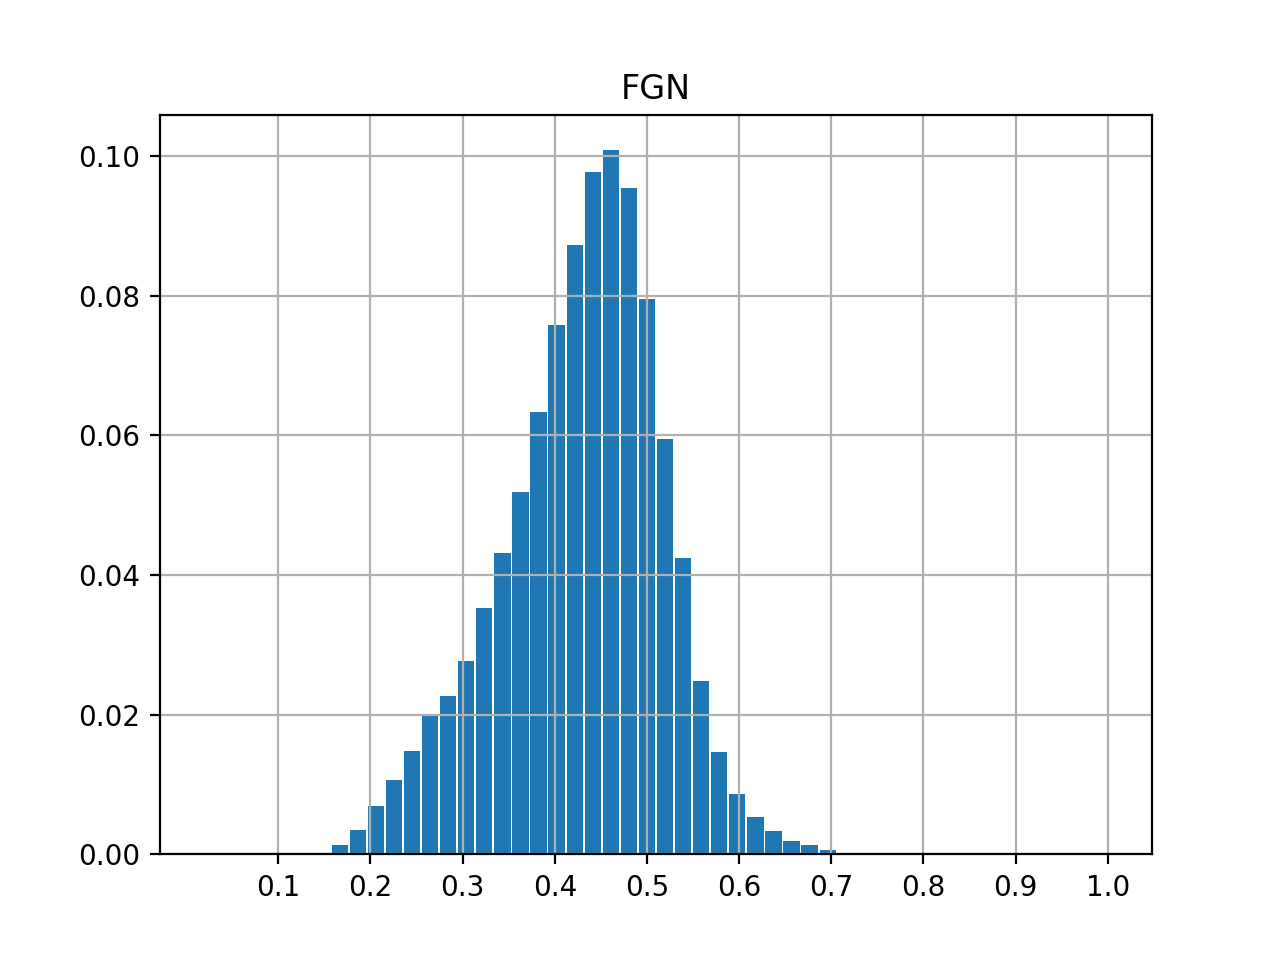

In [53]:
# we only care about the max of the preds
classic_maxes_test = [np.max(p) for p in results_over_mnist['model_[128, 128]_exp_0_preds']]
fgn_maxes_test = [np.max(p) for p in results_over_mnist['fgn_model_[128, 128]_exp_0_preds']]

weights = np.ones_like(fgn_maxes_test)/len(fgn_maxes_test)

# classic
plt.hist(classic_maxes_test, bins=(np.arange(51)+1)/51.0, rwidth=0.9, align='mid', weights=weights)
plt.xticks((np.arange(10)+1)/10.0)
plt.grid(True)
plt.title("Classic")
plt.show()

# fgn
plt.hist(fgn_maxes_test, bins=(np.arange(51)+1)/51.0, rwidth=0.9, align='mid', weights=weights)
plt.xticks((np.arange(10)+1)/10.0)
plt.grid(True)
plt.title("FGN")
plt.show()

Network size []
91.98 vs 92.12
92.12 vs 91.89
92.13 vs 92.01
92.32 vs 92.23
91.96 vs 91.73
92.02 vs 91.09
92.21 vs 87.87
92.16 vs 92.25
91.91 vs 91.44
92.07 vs 91.82
92.21 vs 91.92
92.11 vs 91.79


<IPython.core.display.Javascript object>


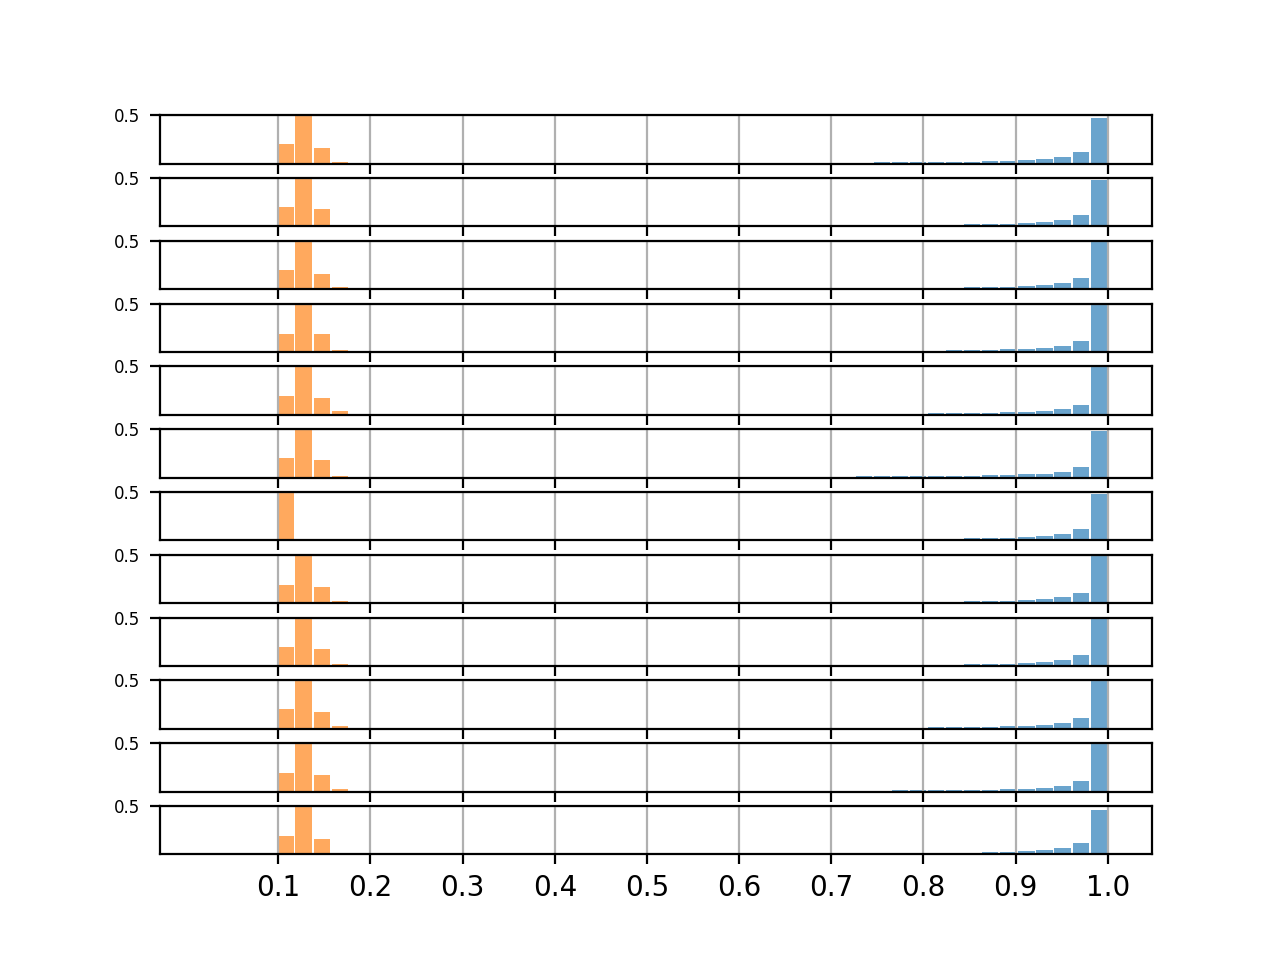

Network size [8]
90.53 vs 89.4


/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


90.71 vs 89.58
89.74 vs 88.52
89.95 vs 86.45
90.57 vs 89.05
90.07 vs 89.46
90.3 vs 88.58
89.44 vs 85.75
89.34 vs 86.92
90.32 vs 87.98
90.12 vs 89.14
90.33 vs 87.28


<IPython.core.display.Javascript object>


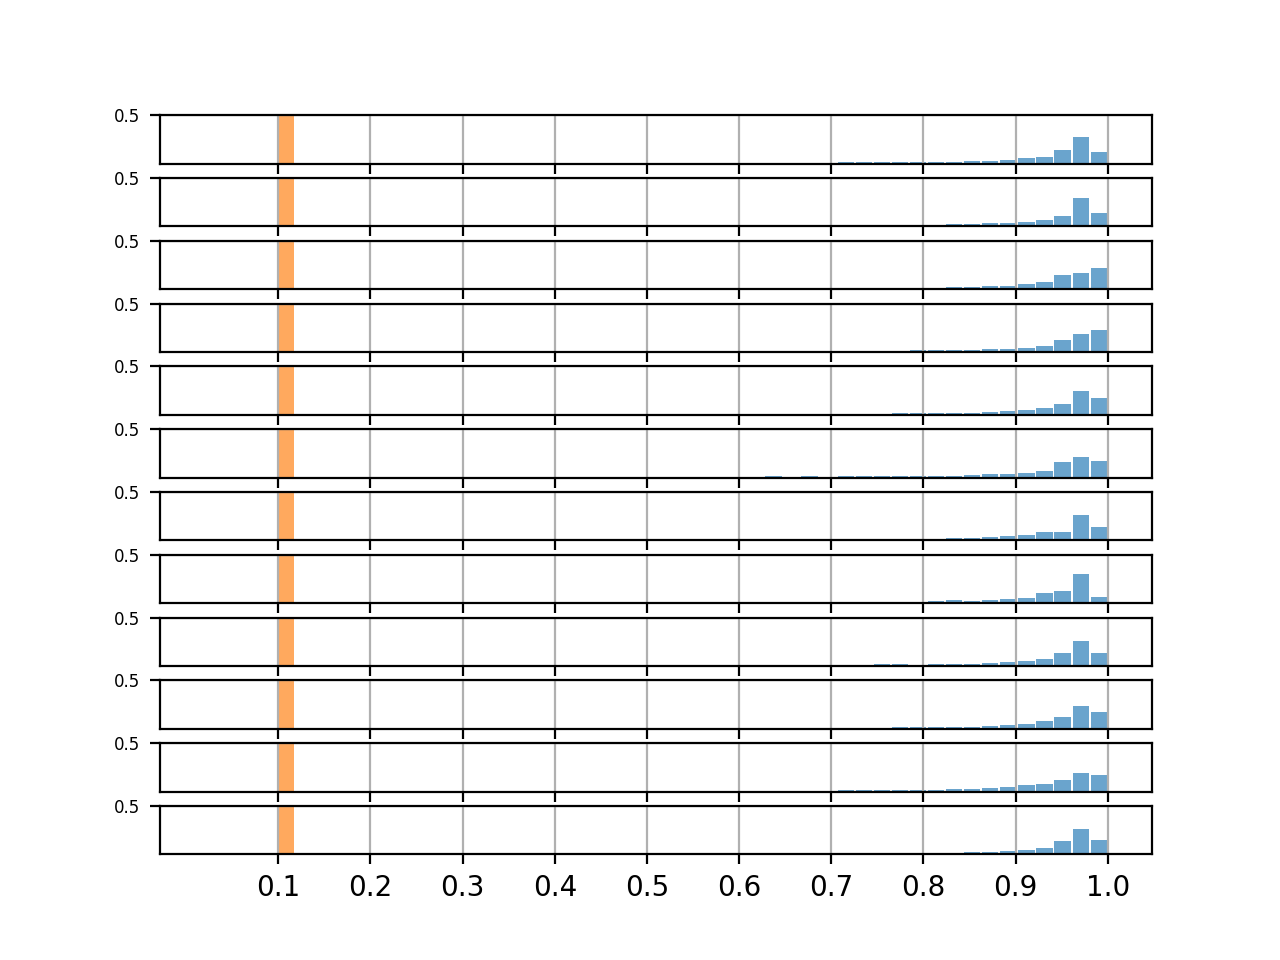

Network size [128]
96.42 vs 94.71
96.23 vs 94.54
96.41 vs 94.76
96.34 vs 94.89
96.22 vs 94.68
96.32 vs 94.8
96.35 vs 95.06
96.21 vs 94.77
95.97 vs 94.77
96.41 vs 94.48
96.4 vs 94.9
96.25 vs 94.75


<IPython.core.display.Javascript object>


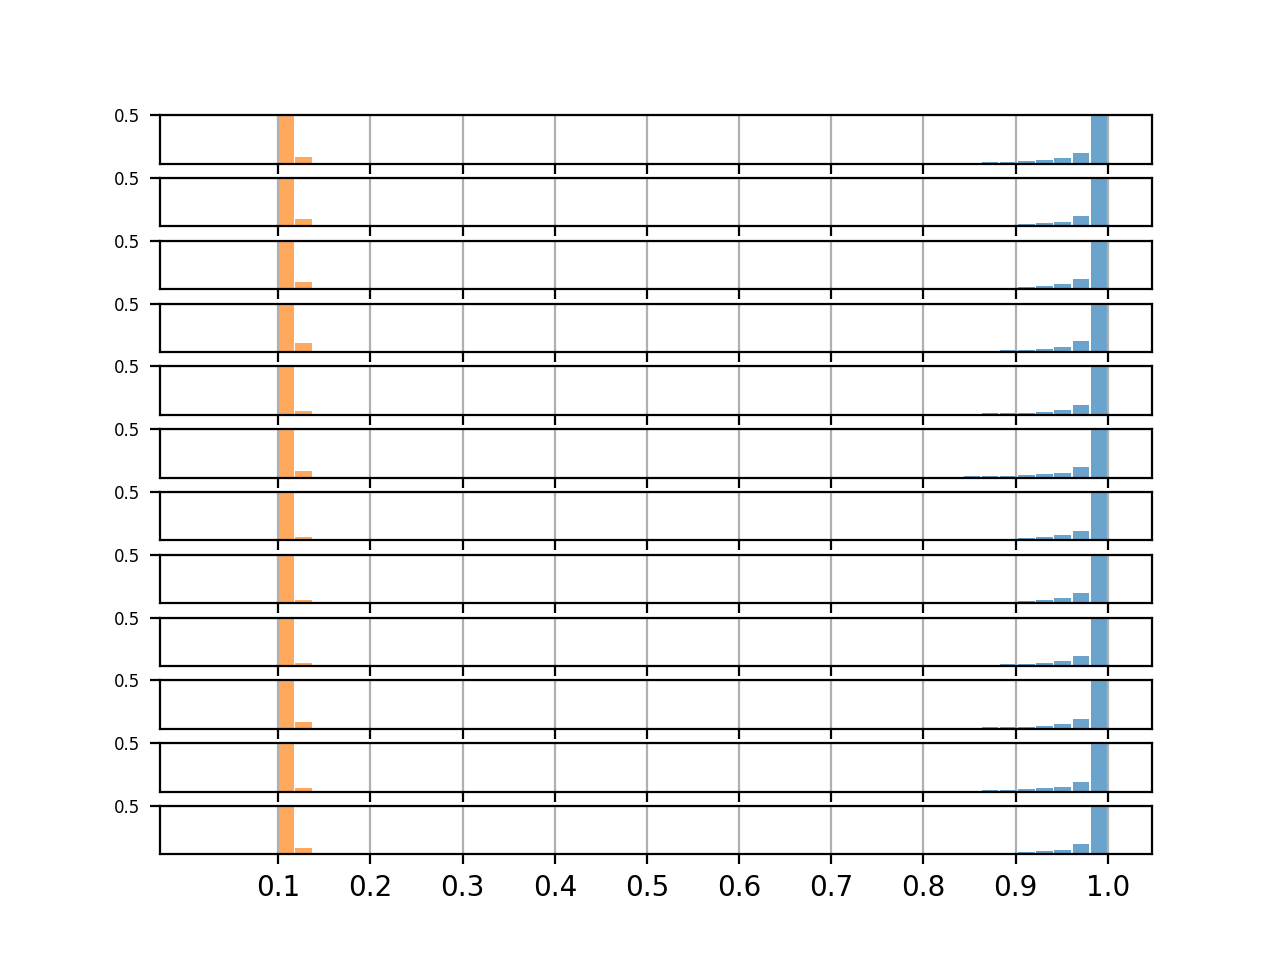

Network size [1024]
96.25 vs 93.04
96.16 vs 93.57
96.51 vs 93.46
96.31 vs 93.1
96.25 vs 94.15
96.49 vs 93.8
96.34 vs 93.79
96.23 vs 93.13
96.47 vs 93.57
96.25 vs 93.39
96.42 vs 93.29
96.32 vs 92.98


<IPython.core.display.Javascript object>


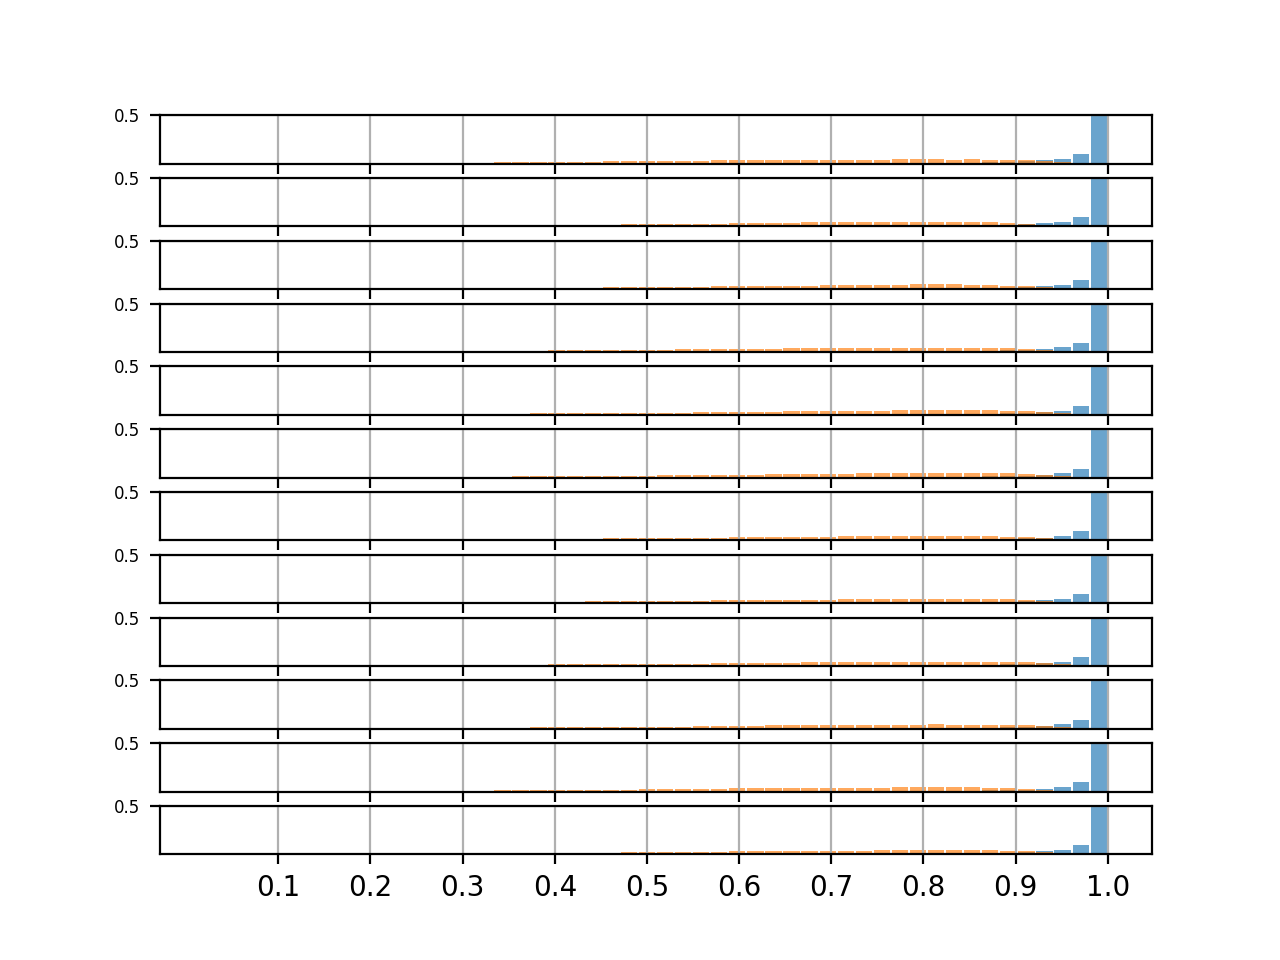

Network size [8, 8]
90.47 vs 89.32
89.68 vs 89.11
90.08 vs 90.03
88.85 vs 87.72
90.03 vs 89.43
90.52 vs 90.11
90.45 vs 89.97
88.46 vs 87.51
90.16 vs 89.1
90.29 vs 89.86
90.09 vs 89.52
90.39 vs 89.29


<IPython.core.display.Javascript object>


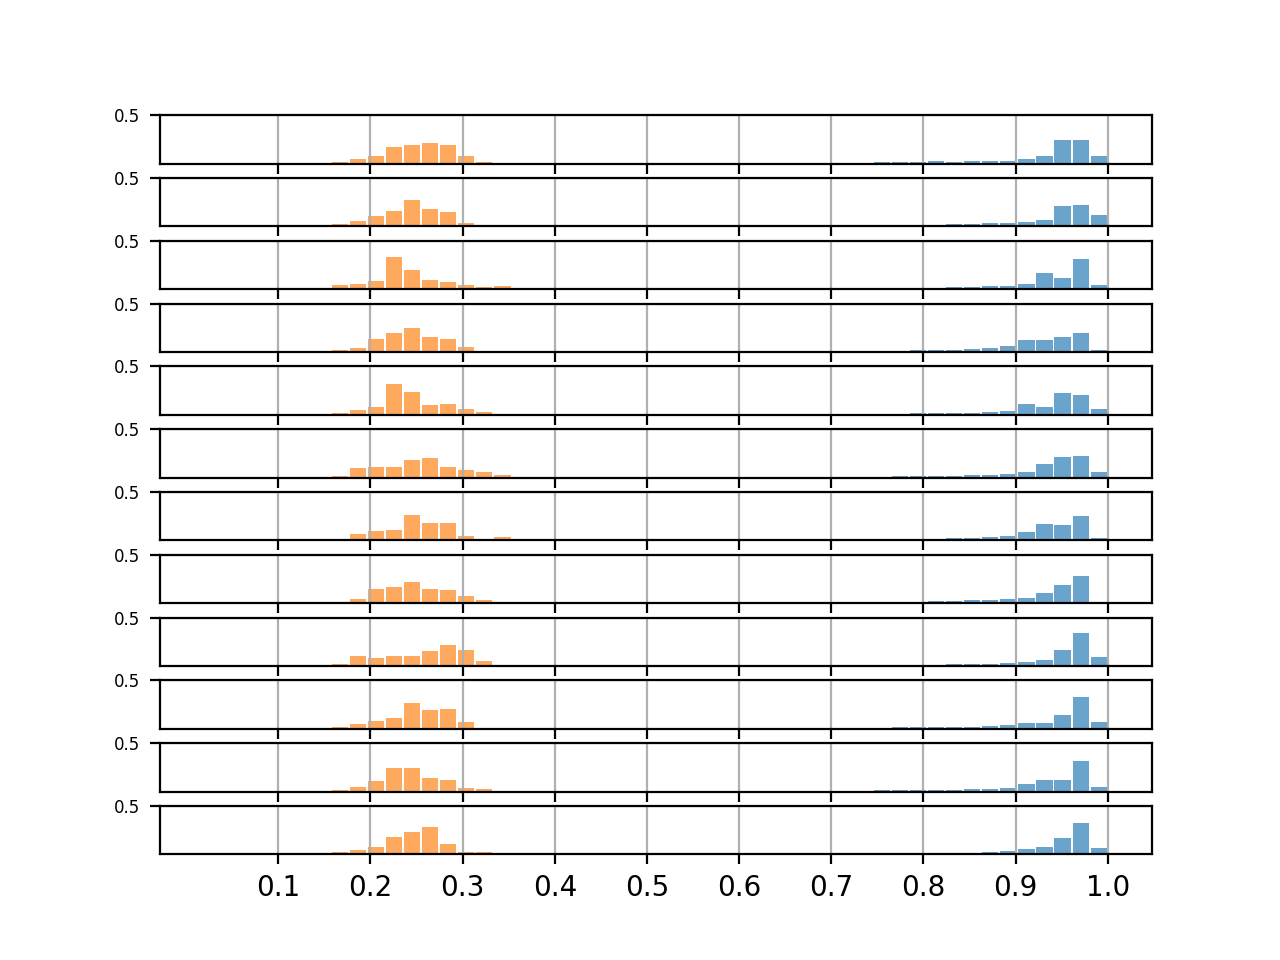

Network size [128, 128]
96.81 vs 96.54
96.79 vs 96.38
96.83 vs 96.54
96.82 vs 96.54
96.84 vs 96.46
96.72 vs 96.51
96.78 vs 96.37
96.96 vs 96.63
96.74 vs 96.55
96.76 vs 96.56
96.84 vs 96.64
96.79 vs 96.35


<IPython.core.display.Javascript object>


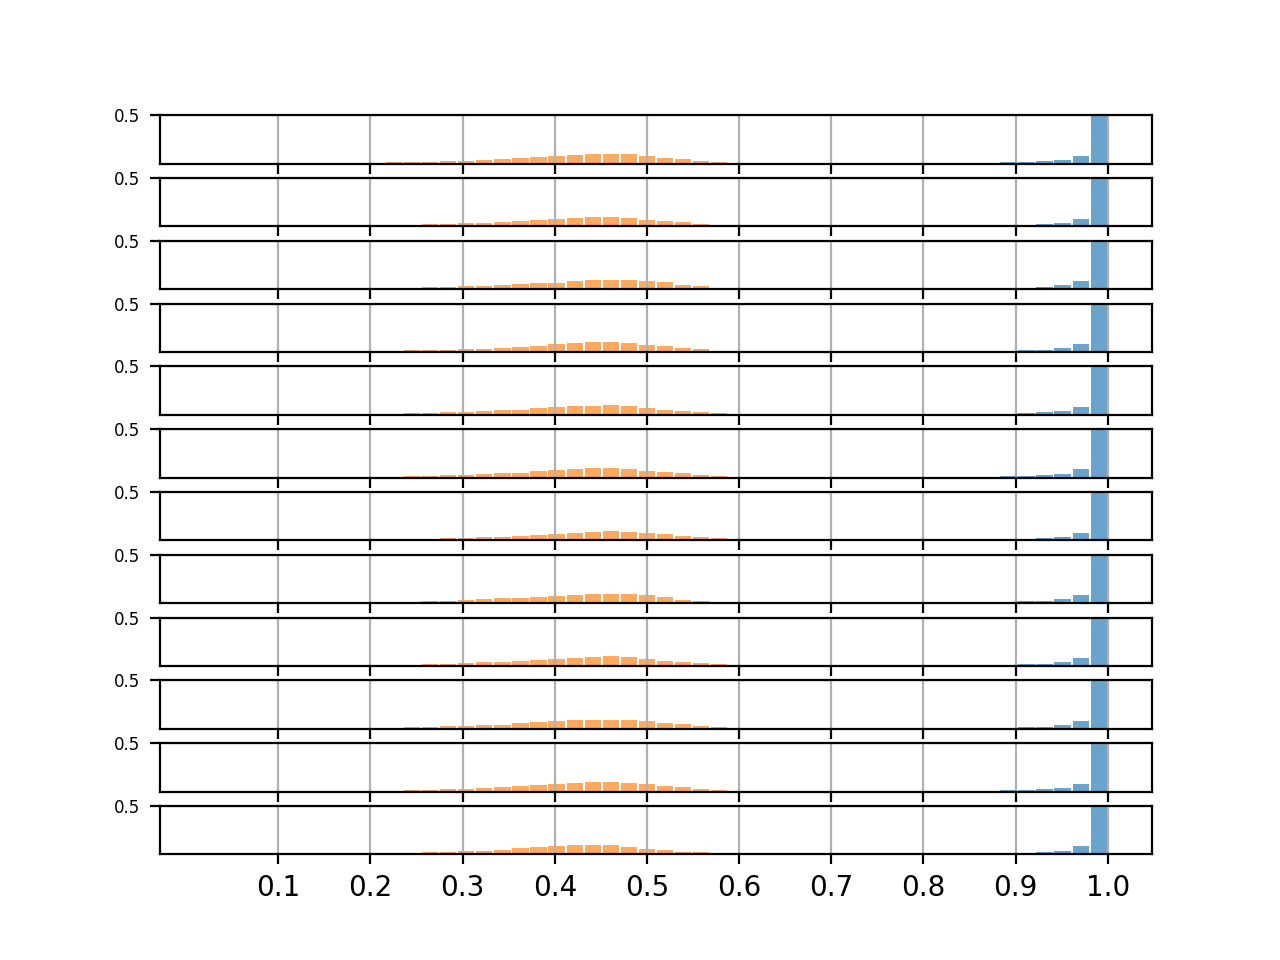

Network size [1024, 1024]
96.41 vs 93.26
96.7 vs 92.57
96.78 vs 92.42
96.68 vs 93.98
96.48 vs 91.93
96.7 vs 93.24
96.49 vs 95.84
96.85 vs 93.6
96.82 vs 92.62
96.62 vs 92.73
96.65 vs 93.17
96.6 vs 92.9


<IPython.core.display.Javascript object>


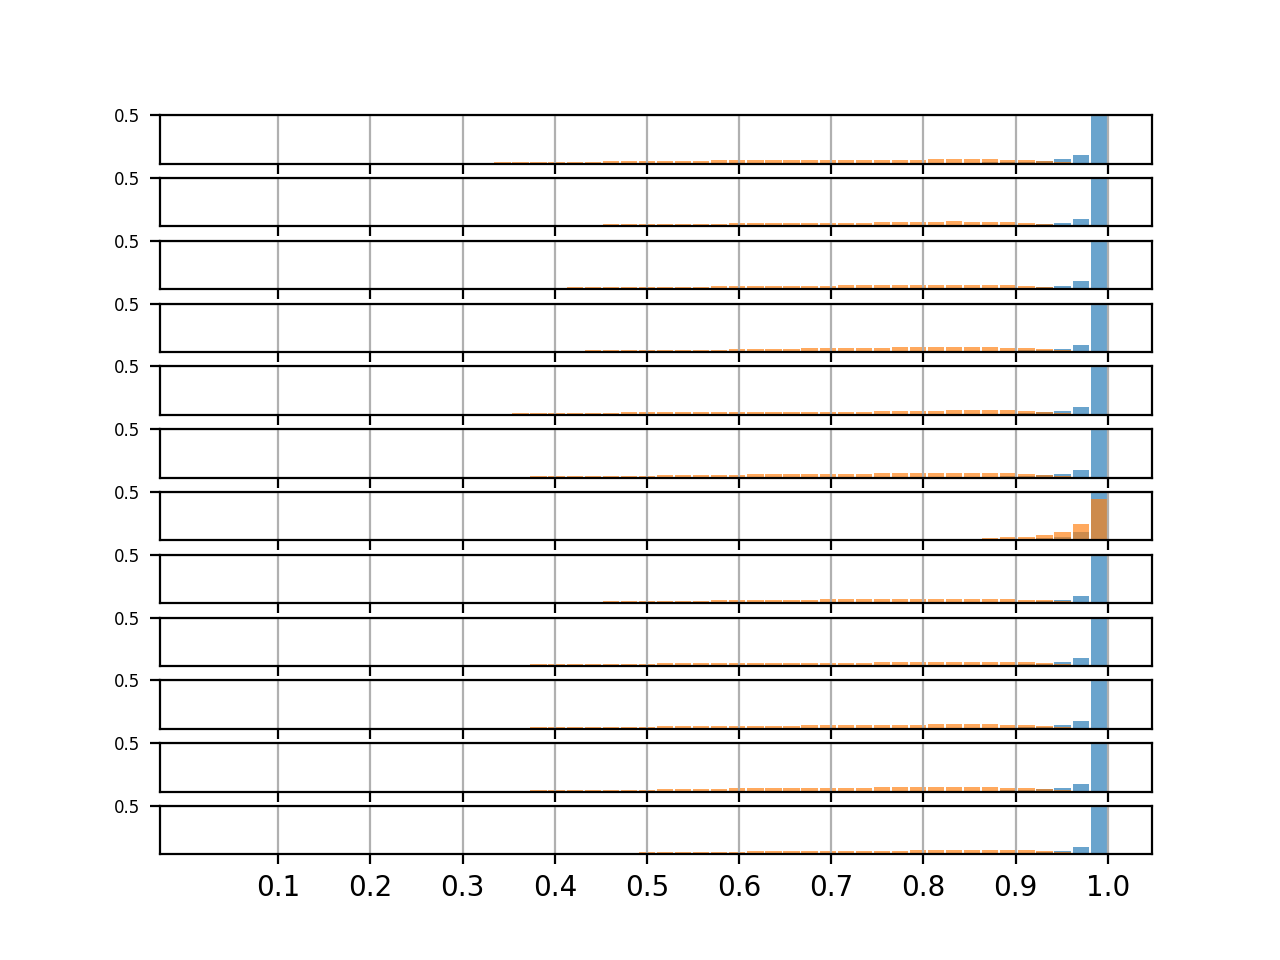

Network size [8, 8, 8]
89.43 vs 87.87
89.87 vs 89.68
90.37 vs 87.71
89.06 vs 88.68
89.53 vs 88.08
88.52 vs 88.18
88.95 vs 88.91
89.46 vs 89.4
87.94 vs 85.91
88.93 vs 88.8
88.5 vs 88.15
89.76 vs 87.39


<IPython.core.display.Javascript object>


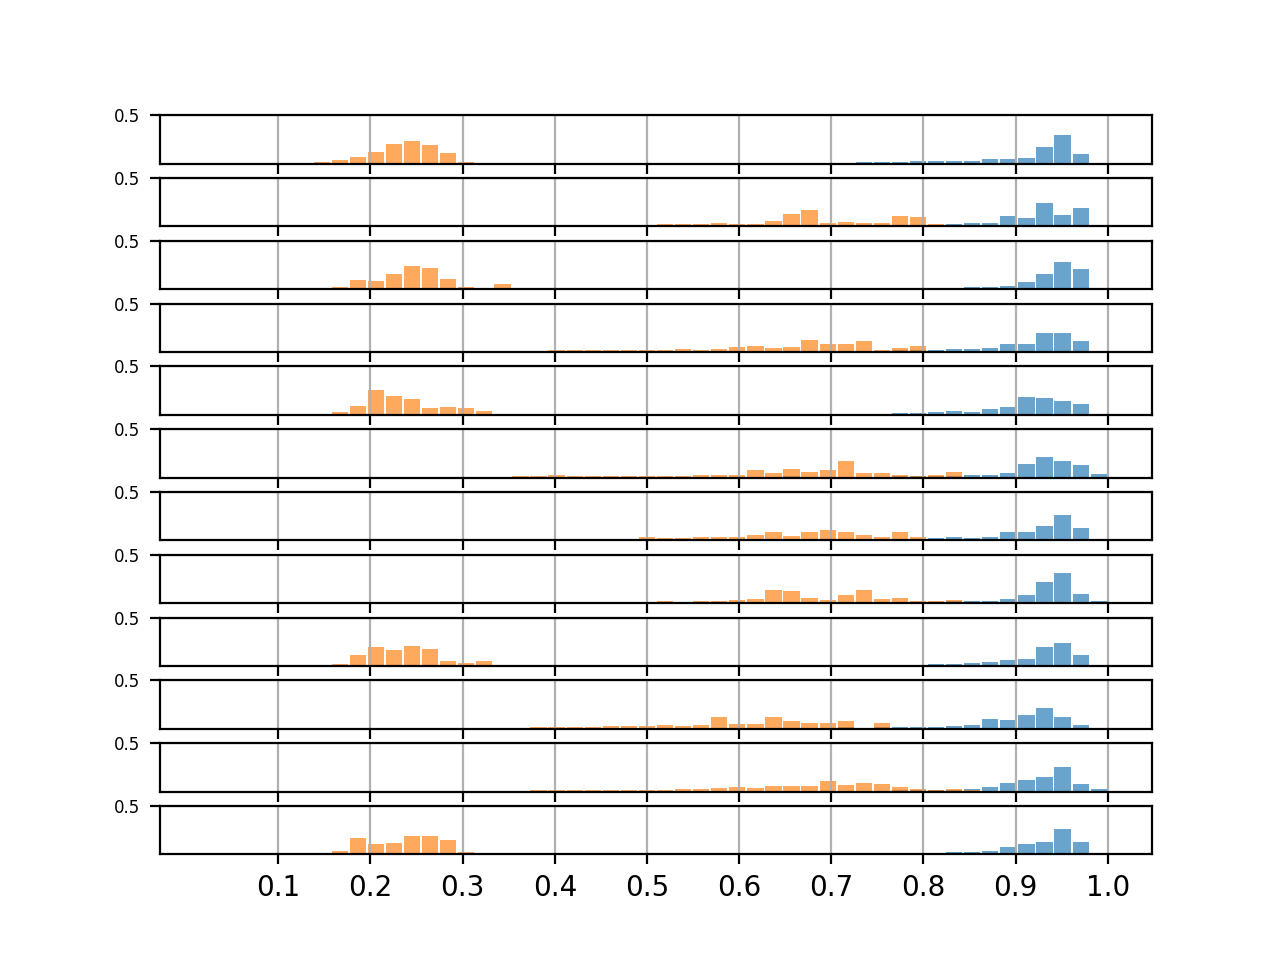

Network size [128, 128, 128]
97.03 vs 96.79
97.14 vs 96.46
97.24 vs 97.07
97.19 vs 96.97
97.09 vs 96.78
97.09 vs 96.8
97.08 vs 96.75
97.09 vs 96.71
97.27 vs 96.8
97.26 vs 96.83
97.23 vs 96.76
97.08 vs 96.77


<IPython.core.display.Javascript object>


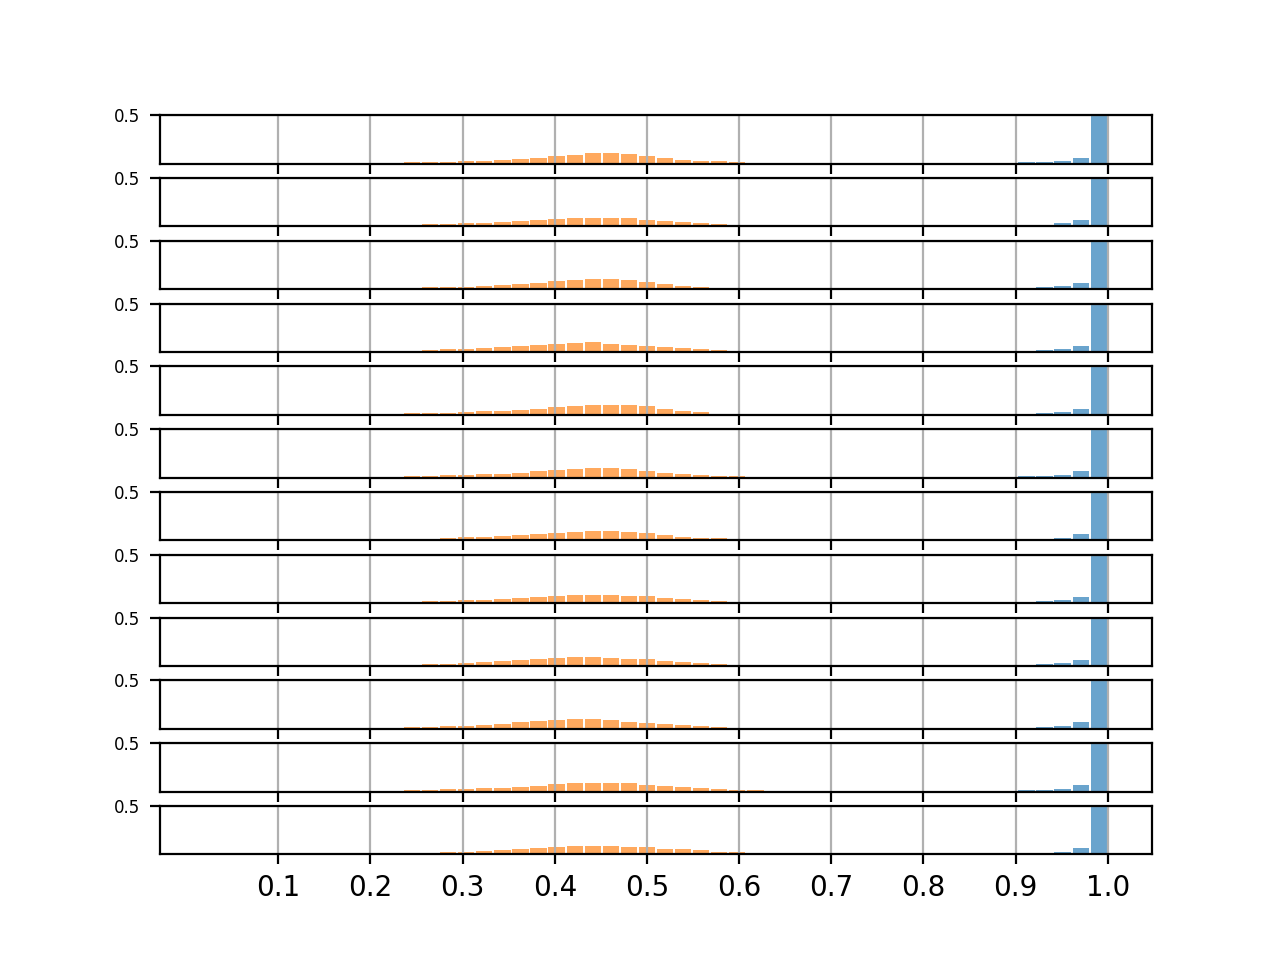

Network size [1024, 1024, 1024]
96.99 vs 92.39
96.5 vs 96.06
96.85 vs 93.0
96.96 vs 92.34
96.54 vs 95.89
96.68 vs 92.02
96.58 vs 96.17
96.74 vs 91.91
96.72 vs 96.25
96.88 vs 93.28
96.95 vs 92.6
96.83 vs 96.41


<IPython.core.display.Javascript object>


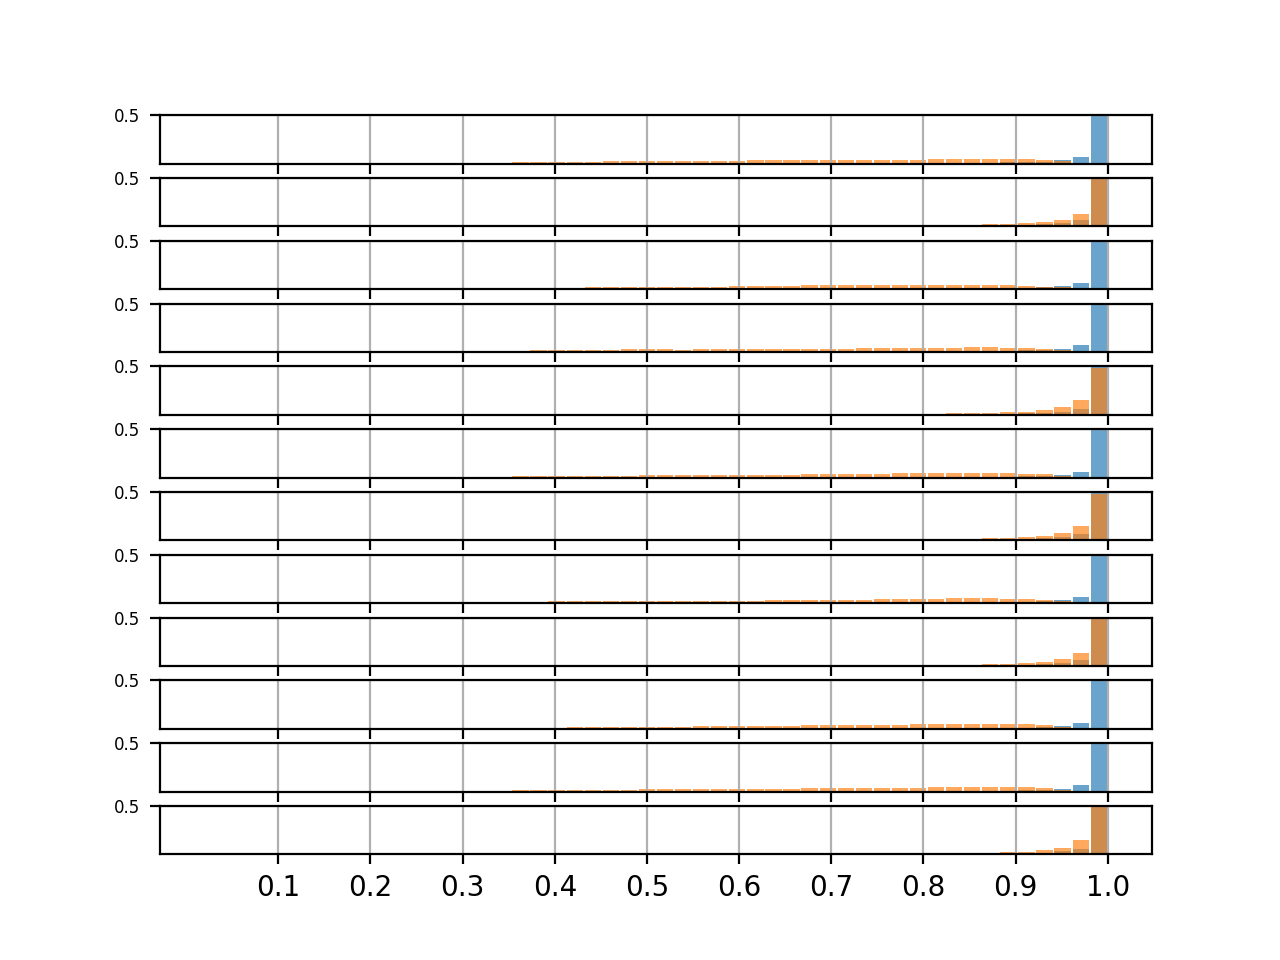

In [54]:
# plot the histogram for each model

for size in network_sizes:
    print("Network size", size)
    subplot_num = 0
    for exp_num in range(12):
#         print("Exp Num", exp_num)
        
        classic_model_name = 'model_'+str(size)+'_exp_'+str(exp_num)
        fgn_model_name = 'fgn_model_'+str(size)+'_exp_'+str(exp_num)
        
        classic_acc = results_over_mnist[classic_model_name+'_acc']
        fgn_acc = results_over_mnist[fgn_model_name+'_acc']
        print(classic_acc, 'vs', fgn_acc)
        
        # we only care about the max of the preds
        classic_maxes = [np.max(p) for p in results_over_mnist[classic_model_name+'_preds']]
        fgn_maxes = [np.max(p) for p in results_over_mnist[fgn_model_name+'_preds']]
        
        subplot_num += 1
        axe = plt.subplot(12,1, subplot_num)
        axe.hist(classic_maxes, bins=(np.arange(51)+1)/51.0, rwidth=0.9, align='mid', weights=weights, alpha=0.665)
        axe.hist(fgn_maxes, bins=(np.arange(51)+1)/51.0, rwidth=0.9, align='mid', weights=weights, alpha=0.665)
        plt.xticks((np.arange(10)+1)/10.0)
        if exp_num != 11: plt.setp(axe.get_xticklabels(), visible=False)
        plt.yticks([0.5], fontsize=6)
        axe.set_ylim([0,0.5])
        plt.grid(True)
        
    plt.subplots_adjust( hspace=0.3)
    plt.show()

In [ ]:
### OLD

In [ ]:
# # create model to be converted
# fgn_model = th.Feedforward_FGN_net(28*28,10,[8])

In [ ]:
# print(fgn_model.state_dict)

In [ ]:
# from collections import OrderedDict 

In [ ]:
# # function that will convert state dicts 
# def convert_state_dict_lin2FGN(lin_state_dict, fgn_state_dict):
#     # given the state dict of a nn.Linear layer, and the fgn_state_dict (for the names)
#     # returns a state dict for FGNlayer
    
#     weights = lin_state_dict.values()[0]
#     bias = lin_state_dict.values()[1]
    
#     new_centers =  torch.Tensor([(-b/np.dot(x,x))*x for x,b in zip(weights.cpu().detach().numpy(), bias.cpu().detach().numpy())]) 
    
#     fgn_state_dict[fgn_state_dict.keys()[0]] = weights
#     fgn_state_dict[fgn_state_dict.keys()[1]] = new_centers
#     fgn_state_dict[fgn_state_dict.keys()[2]] = 0.15*fgn_state_dict[fgn_state_dict.keys()[2]]
    
#     return fgn_state_dict
    

In [ ]:
# def build_lin_layer_state_dicts(model_state_dict):
#     # given a full model state dict, builds a list of state_dicts to be passed later to convert_...
    
#     res_list = []
#     next_sd = OrderedDict()
#     # go through the model
#     for key in model_state_dict:
#         #check if weights
#         if 'weight' in key:
#             # add to next 
#             next_sd.update({key: model_state_dict[key]})
#         if 'bias' in key:
#             # add to next
#             next_sd.update({key: model_state_dict[key]})
#             # add to res_list
#             res_list.append(next_sd)
#             # reset next
#             next_sd = OrderedDict()
    
#     return res_list

In [ ]:
# def build_fgn_layer_state_dicts(model_state_dict):
#     # given a full fgn model state dict, builds a list of state_dicts to be passed later to convert_...
    
#     res_list = []
#     next_sd = OrderedDict()
#     lin_state_dict = OrderedDict()
#     # go through the model
#     for key in model_state_dict:
#         if 'weights' in key:
#             # add to next 
#             next_sd.update({key: model_state_dict[key]})
#         if 'centers' in key:
#             # add to next
#             next_sd.update({key: model_state_dict[key]})
#         if 'sigs' in key:
#             # add to next
#             next_sd.update({key: model_state_dict[key]})
#         if 'pis' in key:
#             # add to next
#             next_sd.update({key: model_state_dict[key]})
#             # add to res_list
#             res_list.append(next_sd)
#             # reset next
#             next_sd = OrderedDict()
    
#     return res_list

In [ ]:
# # convert the model
# classic_list = build_lin_layer_state_dicts(classic_model.state_dict())
# fgn_list = build_fgn_layer_state_dicts(fgn_model.state_dict())

# new_state_dict = OrderedDict()
# for c, f in zip (classic_list, fgn_list):
#     new_state_dict.update(convert_state_dict_lin2FGN(c,f))

In [ ]:
# print(classic_model.state_dict().keys())

In [ ]:
# fgn_model.load_state_dict(new_state_dict)

In [ ]:
# fgn_model.to(device)

In [ ]:
# # apply model to data
# # get predictions 
# predictions = np.array([])
# for data in rand_dataloader:
#     data = data[0].to(device)
#     pred,_ = fgn_model(data)
#     pred = pred.cpu().detach().numpy()
#     try:
#         predictions = np.concatenate((predictions,pred))
#     except:
#         predictions=pred
        
# # for some reason the networks make log_softmax predictions
# predictions = np.exp(predictions)

In [ ]:
# # print first 5 pred
# print(np.round(predictions[:5],decimals=2))
# print("shape:", predictions.shape)

In [ ]:
# debugging, why is 8 neurons in a layer bugging when converted with small sigma?


In [ ]:
# # plot
# fig, axes = plt.subplots(nrows=10, ncols=10)
# for r in range(10):
#     for c in range(10):
        
#         x = rand_dataloader.dataset[10*r+c][0].numpy().reshape((28,28))
        
#         # is the max bigger than rest combined?
#         if np.max(predictions[10*r+c])>=0.5:
#             axes[r,c].spines['bottom'].set_color('tab:red')
#             axes[r,c].spines['top'].set_color('tab:red')
#             axes[r,c].spines['left'].set_color('tab:red')
#             axes[r,c].spines['right'].set_color('tab:red')
        
#         # is the max close to the min?
#         if np.max(predictions[10*r+c])<=0.2:            
#             axes[r,c].spines['bottom'].set_color('tab:blue')
#             axes[r,c].spines['top'].set_color('tab:blue')
#             axes[r,c].spines['left'].set_color('tab:blue')
#             axes[r,c].spines['right'].set_color('tab:blue')
            
#         axes[r,c].spines['bottom'].set_linewidth(3)
#         axes[r,c].spines['top'].set_linewidth(3)
#         axes[r,c].spines['left'].set_linewidth(3)
#         axes[r,c].spines['right'].set_linewidth(3)
#         axes[r,c].tick_params(axis='both', labelbottom='off', labelleft='off', bottom='off', left='off')

#         axes[r,c].imshow(x, cmap=plt.cm.get_cmap('Greys'))
# #         axes[r,c].axis('off')
# plt.subplots_adjust(left=0.3, hspace=0.2)
# plt.show()

In [ ]:
# compare models performance over MNIST

In [ ]:
# # MNIST dataset and dataloader declaration
# # transforms does both the conversion from 0-255 to 0-1
# # and normalizes by the precomputed mean and std

# batch_size = 32

# mnist_train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../MNIST-dataset', train=True, download=False, 
#                    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
#             ])), 
#         batch_size=batch_size, shuffle=True)

# mnist_test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../MNIST-dataset', train=False, download=False, 
#                    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
#             ])), 
#         batch_size=batch_size, shuffle=False)

In [ ]:
# # nll loss function
# def classic_nll_loss_func(model, output, target):
#     return F.nll_loss(output, target)

In [ ]:
# # nll loss function
# def fgn_nll_loss_func(model, output, target):
#     # split output into pred and likelihoods
#     output, likelihood = output
#     return F.nll_loss(output, target)    

In [ ]:
# # number of correct pred function
# def classic_pred_func(output, target):
#     output = output
#     pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
#     correct = pred.eq(target.long().view_as(pred)).sum().item()
#     return correct

In [ ]:
# # number of correct pred function
# def fgn_pred_func(output, target):
#     output,_ = output
#     pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
#     correct = pred.eq(target.long().view_as(pred)).sum().item()
#     return correct

In [ ]:
#Not used # model_optimizer
# optimizer = optim.SGD(filter(lambda p: p.requires_grad, fgn_model.parameters()), lr=0.01, momentum=0.5, nesterov=True)

In [ ]:
# classic_test_res = th.test(classic_model, device, mnist_test_loader, loss_func=classic_nll_loss_func, verbose=True, pred_func=classic_pred_func)

In [ ]:
# fgn_test_res = th.test(fgn_model, device, mnist_test_loader, loss_func=fgn_nll_loss_func, verbose=True, pred_func=fgn_pred_func)

In [ ]:
# ### Part 2 - Test all the pre-trained models
# import os

# all_model_paths = sorted([file for file in os.listdir(model_dir) if file.endswith("_full.pth")])
# networks_sizes = [[], [8], [128], [1024], [8,8], [128,128], [1024,1024], [8,8,8], [128,128,128], [1024,1024,1024]]

In [ ]:
# # results will be of the form:
# # {model_name: res} with res being a list with the predictions for each class
# results_dict = {}

# for size in networks_sizes:
#     for exp_num in range(12):
        
#         # dict load
#         classic_model = th.Classic_MNIST_Net(hidden_l_nums=size)
#         classic_model.to(device)
#         classic_model.load_state_dict(torch.load(model_dir+'/model_'+str(size)+'_exp_'+str(exp_num)+'_state_dict.pth'))

#         # create model to be converted
#         fgn_model = th.Feedforward_FGN_net(28*28,10,size)
        
#         # convert 
#         # convert the model
#         classic_list = build_lin_layer_state_dicts(classic_model.state_dict())
#         fgn_list = build_fgn_layer_state_dicts(fgn_model.state_dict())

#         new_state_dict = OrderedDict()
#         for c, f in zip (classic_list, fgn_list):
#             new_state_dict.update(convert_state_dict_lin2FGN(c,f))
        
#         fgn_model.load_state_dict(new_state_dict)
#         fgn_model.to(device)
            
#         # apply model to data
#         # get predictions 
#         predictions = np.array([])
#         for data in rand_dataloader:
#             data = data[0].to(device)
#             pred,_ = fgn_model(data)
#             pred = pred.cpu().detach().numpy()
#             try:
#                 predictions = np.concatenate((predictions,pred))
#             except:
#                 predictions=pred        

#         # for some reason the networks make log_softmax predictions
#         predictions = np.exp(predictions)

#         # we really only care about the max
#         maxes = [np.max(p) for p in predictions]

#         # add to dict
#         results_dict['model_'+str(size)+'_exp_'+str(exp_num)] = maxes

In [ ]:
# from scipy.stats import describe
# maxes_test = results_dict["model_[8, 8]_exp_1"]
# print("Min of maxes:", np.min(maxes_test))
# print(describe(maxes_test))

In [ ]:
# weights = np.ones_like(maxes_test)/len(maxes_test)
# plt.hist(maxes_test, bins=(np.arange(51)+1)/51.0, rwidth=0.9, align='mid', weights=weights)
# plt.xticks((np.arange(10)+1)/10.0)
# plt.grid(True)
# plt.show()

In [ ]:
# # plot the histogram for each model

# for size in networks_sizes:
#     print("Network size", size)
#     subplot_num = 0
#     for k in results_dict.keys():
#         if str(size) in k:
#             subplot_num += 1
#             axe = plt.subplot(12,1, subplot_num)
#             axe.hist(results_dict[k], bins=(np.arange(51)+1)/51.0, rwidth=0.9, align='mid', weights=weights)
#             plt.xticks((np.arange(10)+1)/10.0)
#         #     plt.yticks((np.arange(0,11,2))/10.0)
#             plt.grid(True)
#     plt.show()

